In [736]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diploma/data.csv


In [737]:
# импорт библиотек

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import zipfile
import PIL
from PIL import ImageOps, ImageFilter
import re
import ast
from datetime import time, date, datetime
import random

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-paper')


from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, roc_curve, roc_auc_score
from sklearn import metrics
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import VotingRegressor
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor, Pool, cv

# keras
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.losses import MeanAbsolutePercentageError

#from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, DataCollatorWithPadding

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_columns', 550) # больше колонок

os.environ['PYTHONHASHSEED']=str(42)

In [738]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
ITERATIONS = 200

In [739]:
DIR_DATA  = '../input/diploma/'

In [740]:
data_d = pd.read_csv(DIR_DATA+'data.csv')

# Вспомогательные функции расчета метрик.

In [741]:
# Функция расчета ошибки
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [742]:
# Функция расчета ошибки для логарифмированной целевой переменнной
def mape_log(y_true, y_pred):
    return np.mean(np.abs((np.exp(y_pred)-np.exp(y_true))/np.exp(y_true)))

In [743]:
def print_regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f'MSE = {mse:.2f}, RMSE = {rmse:.2f}')

In [744]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

Удалено, потому что громоздко.

# Анализ целевой переменной.

In [745]:
data_d.head(10)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"
5,for sale,NaN,townhouse,1624 S Newkirk St,NaN,"{'atAGlanceFacts': [{'factValue': '1920', 'fac...",NaN,Philadelphia,"[{'rating': [], 'data': {'Distance': [], 'Grad...",897 sqft,19145,2 Beds,PA,2.0,NaN,NaN,PAPH847006,"$209,000"
6,Active,NaN,Florida,552 Casanova Ct,NaN,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",NaN,POINCIANA,"[{'rating': ['3', '3', '1', 'NR'], 'data': {'D...","1,507",34759,NaN,FL,One,NaN,NaN,S5026943,"181,500"
7,Active,NaN,NaN,6094 Mingle Dr,NaN,"{'atAGlanceFacts': [{'factValue': '1976', 'fac...",NaN,Memphis,"[{'rating': ['4', '2', '2'], 'data': {'Distanc...",NaN,38115,NaN,TN,NaN,NaN,NaN,10063506,"68,000"
8,Active,NaN,Single Family Home,11182 Owl Ave,2,"{'atAGlanceFacts': [{'factValue': '1970', 'fac...",NaN,Mason City,"[{'rating': ['2', '2', '4', '7', '4', 'NR'], '...",3588,50401,3,IA,NaN,NaN,NaN,190988,"$244,900"
9,NaN,NaN,Single Family,8612 Cedar Plains Ln,3,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Houston,"[{'rating': ['4/10', '3/10', '2/10'], 'data': ...","1,930",77080,3,TX,2.0,NaN,NaN,73968331,"$311,995"


# Вспомогательная функция извлечения числа из записи доллара.

In [746]:
def dollar_clean(string):
    i=0
    string_interm=re.findall('[0-9]+', string)
    
    if string_interm==[]:

        return np.NaN
    else:
        dollar_res=''
        while i<=(len(string_interm)-1):
            dollar_res=dollar_res + string_interm[i]
            i=i+1
        return float(dollar_res)


In [747]:
data_d.target = data_d.target.apply(lambda x: dollar_clean(str(x)))

In [748]:
data_d['target'].isna().unique()

array([False,  True])

In [749]:
data_d.loc[data_d['target'].isna() == True]

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
61,NaN,NaN,Single Family,7353 Boysenberry Ct,2.0,"{'atAGlanceFacts': [{'factValue': '1983', 'fac...",Yes,Jacksonville,"[{'rating': ['7/10', '2/10', '4/10'], 'data': ...","1,446 sqft",32244,3,FL,1,NaN,NaN,NaN,NaN
94,Pre-foreclosure / auction,NaN,Townhouse,20663 Fm 2154 Rd,Bathrooms: 4,"{'atAGlanceFacts': [{'factValue': '2016', 'fac...",Yes,College Station,"[{'rating': ['NA', '2/10', 'NA'], 'data': {'Di...","Total interior livable area: 4,179 sqft",77845,4 bd,TX,2.0,NaN,NaN,NaN,NaN
121,/ auction,NaN,Single Family,3719 Suffolk St,2,"{'atAGlanceFacts': [{'factValue': '1972', 'fac...",Yes,Durham,"[{'rating': ['2/10', '5/10', '4/10'], 'data': ...","2,327",27707,3,NC,0.0,NaN,NaN,NaN,NaN
169,NaN,NaN,Single Family,8201 Waterford Ave,2.0,"{'atAGlanceFacts': [{'factValue': '1985', 'fac...",NaN,Tamarac,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...","1,280 sqft",33321,2,FL,1.0,NaN,NaN,NaN,NaN
174,Pre-foreclosure / auction,NaN,Single Family,17508 Puritas Ave,Bathrooms: 2,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",NaN,Cleveland,"[{'rating': ['2/10', '2/10'], 'data': {'Distan...","Total interior livable area: 1,209 sqft",44135,2 bd,OH,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376495,recently sold,NaN,single-family home,7433 Creekland Dr,2 Baths,"{'atAGlanceFacts': [{'factValue': '2003', 'fac...",NaN,Reno,"[{'rating': ['None/10', '5/10', '3/10'], 'data...","1,082 sqft",89506,2 Beds,NV,1,NaN,NaN,NaN,NaN
376528,foreclosure,NaN,apartment,5652 S Justine St,2 Baths,"{'atAGlanceFacts': [{'factValue': '2009', 'fac...",NaN,Chicago,"[{'rating': ['1/10', '1/10', '2/10'], 'data': ...","2,351 sqft",60636,6 Beds,IL,NaN,NaN,NaN,NaN,NaN
376577,Foreclosed,NaN,Single Family,1851 W Landstreet Rd # 3233,NaN,"{'atAGlanceFacts': [{'factValue': '1973', 'fac...",NaN,Orlando,"[{'rating': ['4/10', '2/10', '5/10'], 'data': ...",Total interior livable area: 620 sqft,32809,-- bd,FL,NaN,NaN,NaN,NaN,NaN
376937,NaN,NaN,NaN,8501 NW 53rd Ter,NaN,"{'atAGlanceFacts': [{'factValue': None, 'factL...",NaN,Doral,"[{'rating': ['10/10', '8/10'], 'data': {'Dista...",NaN,33166,1.74 acres,FL,NaN,NaN,NaN,NaN,NaN


In [750]:
data_d.dropna(axis=0,subset=['target'],inplace=True)

In [751]:
data_d.head(3)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,418000.0
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,310000.0
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,2895000.0


In [752]:
data_d['target'].isna().unique()

array([False])

<AxesSubplot:xlabel='target', ylabel='Density'>

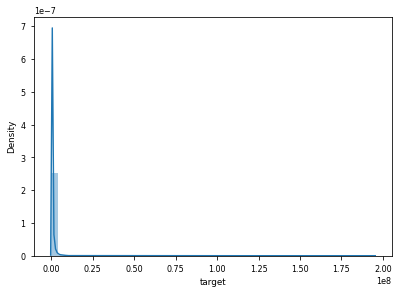

In [753]:
sns.distplot(data_d['target'])

Предварительное грубое удаление выбросов.

In [754]:
data_d.loc[data_d['target'].median()]

status                                                     Active
private pool                                                  NaN
propertyType                        Condo/Townhome/Row Home/Co-Op
street                              1080 Wisconsin Ave NW Apt 304
baths                                                         1.5
homeFacts       {'atAGlanceFacts': [{'factValue': '1981', 'fac...
fireplace                                                     NaN
city                                                   Washington
schools         [{'rating': ['8', '8', '8', '8', '9', '9', 'NR...
sqft                                                          946
zipcode                                                     20007
beds                                                            1
state                                                          DC
stories                                                        3+
mls-id                                                        NaN
PrivatePoo

In [755]:
data_d['target'].mean()

644757.5030263888

In [756]:
data_d.loc[data_d['target']>data_d['target'].mean()]

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,2895000.0
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,2395000.0
10,for sale,NaN,coop,14205 Roosevelt Ave #512,2 Baths,"{'atAGlanceFacts': [{'factValue': '1965', 'fac...",NaN,Flushing,"[{'rating': ['2/10', '8/10', '10/10'], 'data':...","1,300 sqft",11354,3 Beds,NY,NaN,NaN,NaN,3087630,669000.0
15,New,NaN,2 Story,930 52nd St,NaN,"{'atAGlanceFacts': [{'factValue': '1905', 'fac...",NaN,Brooklyn,"[{'rating': ['8', '8', '3'], 'data': {'Distanc...",NaN,11219,NaN,NY,NaN,NaN,NaN,3182740,1650000.0
17,Active,NaN,Townhouse,24 W 126th St,NaN,"{'atAGlanceFacts': [{'factValue': '1899', 'fac...",NaN,New York,"[{'rating': ['2', '5', '1', '2'], 'data': {'Di...","3,325",10027,NaN,NY,NaN,NaN,NaN,4975368,2650000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377168,for sale,NaN,single-family home,24080 Tuscany Ct,5 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Bonita Springs,"[{'rating': ['3/10', '8/10', '4/10', '5/10', '...","5,992 sqft",34134,4 Beds,FL,NaN,NaN,yes,219077435,2495000.0
377174,for sale,NaN,single-family home,1107 E Euclid Ave,NaN,"{'atAGlanceFacts': [{'factValue': '1938', 'fac...",NaN,San Antonio,"[{'rating': ['4/10', '5/10', '3/10'], 'data': ...",950 sqft,78212,2 Beds,TX,1.0,NaN,yes,1391618,799500.0
377179,For sale,NaN,Condo,2238 11th St NW APT 2,3,"{'atAGlanceFacts': [{'factValue': '2010', 'fac...",NaN,Washington,"[{'rating': ['3/10', '3/10'], 'data': {'Distan...","1,417",20001,2,DC,3.0,NaN,NaN,DCDC444306,799000.0
377180,NaN,NaN,Single Family,20800 NE 23rd Ave,6.0,"{'atAGlanceFacts': [{'factValue': '1990', 'fac...",NaN,Miami,"[{'rating': ['10/10', '5/10'], 'data': {'Dista...","4,017",33180,5,FL,0.0,NaN,Yes,A10702700,1249000.0


In [757]:
data_d = data_d[(data_d['target'] < 550000)]

<AxesSubplot:xlabel='target', ylabel='Density'>

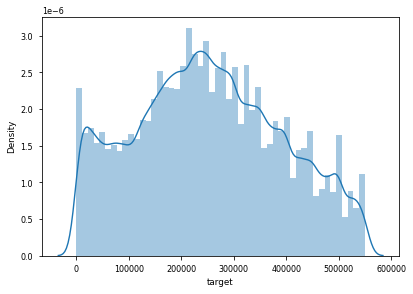

In [758]:
sns.distplot(data_d['target'])

{'bodies': [<matplotlib.collections.PolyCollection at 0x7efe723d0b50>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7efe723d0b10>,
 'cmins': <matplotlib.collections.LineCollection at 0x7efe723d0b90>,
 'cbars': <matplotlib.collections.LineCollection at 0x7efe723d0990>}

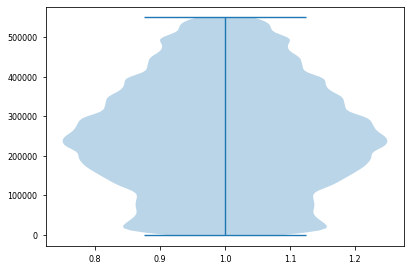

In [759]:
plt.violinplot(data_d['target'])

In [760]:
data_d['target'].isna().unique()

array([False])

In [761]:
data_d.loc[data_d['target']==0]

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target


In [762]:
data_d.loc[data_d['target'].min()]

status                                                   for sale
private pool                                                  NaN
propertyType                                   single-family home
street                                          12911 E Heroy Ave
baths                                                     3 Baths
homeFacts       {'atAGlanceFacts': [{'factValue': '2019', 'fac...
fireplace                                                     NaN
city                                               Spokane Valley
schools         [{'rating': ['4/10', 'None/10', '4/10'], 'data...
sqft                                                   1,947 sqft
zipcode                                                     99216
beds                                                       3 Beds
state                                                          WA
stories                                                       2.0
mls-id                                                        NaN
PrivatePoo

In [763]:
#data_d.target = np.log(data_d.target[data_d.target > 0])

In [764]:
#data_d['target'].isna().unique()

# Обработка признака homeFacts.

In [765]:
def facts_extraction(slovar):
    if slovar.find('atAGlanceFacts')>-1:
        slovar1 = eval(slovar)
       # print(type(slovar1))
        #print(slovar1)
        slovar2=slovar1.get('atAGlanceFacts')
       # print(type(slovar2))
       # print(slovar2)
        
        lst = ['']
        for i in slovar2:
            
            lst.append(i.get('factValue'))
        lst_res=lst[1:]
        return lst_res
            
    else: return np.NaN


In [766]:
data_d.homeFacts = data_d.homeFacts.apply(lambda x: facts_extraction(x))
t = data_d['homeFacts']
t_lst = t.tolist()
columns = ['Year built','Remodeled year','Heating','Cooling','Parking','lotsize','price_sqft']
t1 = pd.DataFrame(t_lst, columns = columns)
data_d = data_d.join(t1)

In [767]:
data_d.head(3)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"[2019, , Central A/C, Heat Pump, , , None, $144]",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,418000.0,2019,,"Central A/C, Heat Pump",,,None,$144
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"[2019, , , , , 5828 sqft, $159/sqft]",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,310000.0,2019,,,,,5828 sqft,$159/sqft
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"[, , , , , 10,019 sqft, None]",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,5000.0,2006,2006,"Electric, Heat Pump",Central Air,,"4,996 Sq. Ft.",$120 / Sq. Ft.


# Разбор признака школы.

In [768]:
data_d.schools = data_d.schools.apply(lambda x: eval(x[1:-1]))
t = data_d['schools']
t_lst = t.tolist()
t5_lst = []
for i in t_lst:
    i1 = dict([('rating', i.get('rating')), ('Distance', (i.get('data')).get('Distance')), ('Grades', (i.get('data')).get('Grades')),('name',i.get('name'))])
    t5_lst.append(i1)

df_lst = pd.DataFrame(t5_lst,dtype=str)
data_d = data_d.join(df_lst)

# Площадь

Вспомогательная функция для получения численного значения площади. Если значение некорректно, возвращает NaN.

In [769]:
def extract_num_recurr_sqft(stroka,first_digit,len_s,i):
    if i == len_s and stroka[i].isdigit():
        return (float(first_digit + str(stroka[i])))
    elif i < len_s and (stroka[i].isdigit() or stroka[i] == '.'):
        return extract_num_recurr_sqft(stroka, (first_digit + str(stroka[i])), len_s, i+1)
    elif i < len_s and stroka[i] == ',':
        return extract_num_recurr_sqft(stroka, first_digit, len_s, i+1)
    else: return(float(first_digit))
                        
def extract_num_sqft(stroka,len_s,i):
  
    if i == len_s and not stroka[i].isdigit():
        return np.NaN
    elif i == len_s and stroka[i].isdigit():
        return float(stroka[i])
    elif i < len_s and stroka[i].isdigit():
        return extract_num_recurr_sqft(stroka,str(stroka[i]),len_s,i+1)
    else: return extract_num_sqft(stroka,len_s,i+1)

def main_extract_num_sqft(stroka):   
    len_s=len(stroka)-1
    
    return extract_num_sqft(stroka,len_s,0)

In [770]:
data_d.sqft = data_d.sqft.apply(lambda x: main_extract_num_sqft(str(x)))

In [771]:
data_d['sqft'].value_counts()

0.0        10651
1200.0      1217
1000.0       897
1100.0       795
1500.0       765
           ...  
51774.0        1
24560.0        1
4780.0         1
6434.0         1
7644.0         1
Name: sqft, Length: 5812, dtype: int64

Вместо нулевых значений подставляю нан для упрощения последующей замены.

In [772]:
data_d.sqft = data_d.sqft.apply(lambda x: np.NaN if x==0.0 else x)

In [773]:
t_df = data_d.loc[data_d['sqft'].isna() == True]

<AxesSubplot:xlabel='sqft'>

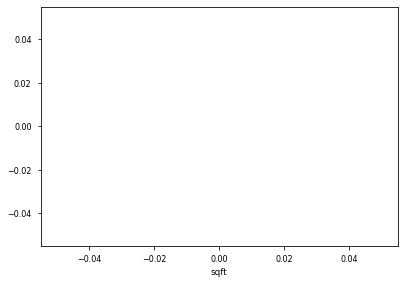

In [774]:
sns.distplot(t_df['sqft'])

In [775]:
data_d['sqft'].value_counts()

1200.0     1217
1000.0      897
1100.0      795
1500.0      765
1400.0      748
           ... 
51774.0       1
24560.0       1
4780.0        1
6434.0        1
7644.0        1
Name: sqft, Length: 5811, dtype: int64

In [776]:
data_d['sqft'].unique()

array([2.90000000e+03, 1.94700000e+03,            nan, ...,
       7.20000000e+01, 4.56602479e+08, 7.64400000e+03])

In [777]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274467 entries, 0 to 377184
Data columns (total 29 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          245007 non-null  object 
 1   private pool    2712 non-null    object 
 2   propertyType    250827 non-null  object 
 3   street          274466 non-null  object 
 4   baths           192550 non-null  object 
 5   homeFacts       274467 non-null  object 
 6   fireplace       66993 non-null   object 
 7   city            274447 non-null  object 
 8   schools         274467 non-null  object 
 9   sqft            233630 non-null  float64
 10  zipcode         274467 non-null  object 
 11  beds            204895 non-null  object 
 12  state           274467 non-null  object 
 13  stories         167742 non-null  object 
 14  mls-id          19144 non-null   object 
 15  PrivatePool     22559 non-null   object 
 16  MlsId           224520 non-null  object 
 17  target    

In [778]:
data_d.loc[data_d['sqft'].min()]

status                                                     for sale
private pool                                                    NaN
propertyType                                     single-family home
street                                            12911 E Heroy Ave
baths                                                       3 Baths
homeFacts                      [2019, , , , , 5828 sqft, $159/sqft]
fireplace                                                       NaN
city                                                 Spokane Valley
schools           {'rating': ['4/10', 'None/10', '4/10'], 'data'...
sqft                                                         1947.0
zipcode                                                       99216
beds                                                         3 Beds
state                                                            WA
stories                                                         2.0
mls-id                                          

<AxesSubplot:xlabel='sqft', ylabel='Density'>

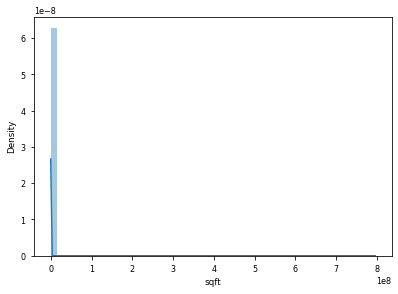

In [779]:
sns.distplot(data_d['sqft'])

In [780]:
data_d.loc[data_d['sqft'].median()]

status                                                     for sale
private pool                                                    NaN
propertyType                                                  condo
street                                        2924 Collins Ave #503
baths                                                       2 Baths
homeFacts            [1980, 1980, Electric, Central, , , $487/sqft]
fireplace                                                       NaN
city                                                    Miami Beach
schools           {'rating': ['5/10', '10/10', '4/10', '10/10', ...
sqft                                                         1077.0
zipcode                                                       33140
beds                                                         2 Beds
state                                                            FL
stories                                                         NaN
mls-id                                          

In [781]:
data_d['sqft_big'] = data_d['sqft'].apply(lambda x: True if x > 500000 else False)

In [782]:
data_d.head(3)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,sqft_big
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"[2019, , Central A/C, Heat Pump, , , None, $144]",Gas Logs,Southern Pines,"{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR...",2900.0,28387,4,NC,NaN,NaN,NaN,611019,418000.0,2019,,"Central A/C, Heat Pump",,,None,$144,"['4', '4', '7', 'NR', '4', '7', 'NR', 'NR']","['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10.5...","['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', ...","['Southern Pines Elementary School', 'Southern...",False
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"[2019, , , , , 5828 sqft, $159/sqft]",NaN,Spokane Valley,"{'rating': ['4/10', 'None/10', '4/10'], 'data'...",1947.0,99216,3 Beds,WA,2.0,NaN,NaN,201916904,310000.0,2019,,,,,5828 sqft,$159/sqft,"['4/10', 'None/10', '4/10']","['1.65mi', '1.32mi', '1.01mi']","['9-12', '3-8', 'PK-8']","['East Valley High School&Extension', 'Eastval...",False
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"[, , , , , 10,019 sqft, None]",NaN,Palm Bay,"{'rating': ['4/10', '5/10', '5/10'], 'data': {...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,5000.0,2006,2006,"Electric, Heat Pump",Central Air,,"4,996 Sq. Ft.",$120 / Sq. Ft.,"['3', '3', '1', 'NR']","['0.8 mi', '8.3 mi', '4.2 mi', '2.0 mi']","['Preschool to 4', 'Preschool to 12', '5 to 8'...","['Palmetto Elementary School', 'Haines City Se...",False


In [783]:
data_d.sqft = data_d.sqft.apply(lambda x: 500001 if x>500000 else x)

# Визуализация признака площадь

<AxesSubplot:xlabel='sqft', ylabel='Density'>

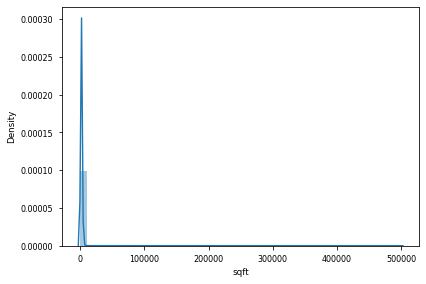

In [784]:
sns.distplot(data_d['sqft'])


Text(0.5, 1.0, 'Зависимость цены от площади')

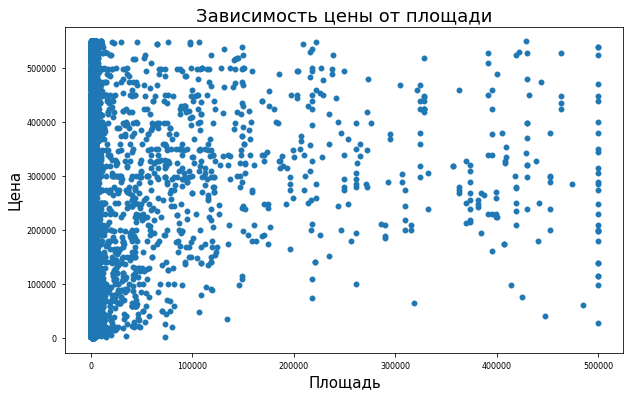

In [785]:
x = data_d['sqft']
y = data_d['target']
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Площадь', fontsize = 15)
plt.ylabel('Цена', fontsize = 15)
plt.title('Зависимость цены от площади', fontsize = 18)

<AxesSubplot:xlabel='sqft'>

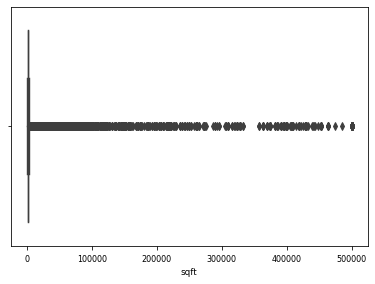

In [786]:
sns.boxplot(data_d['sqft'])

# Спальни - приведение к численному виду.

In [787]:
data_d['beds'].value_counts()

3 Beds         42508
4 Beds         24565
3              24141
2 Beds         20274
4              12805
               ...  
4,599 sqft         1
3,354 sqft         1
10.02 acres        1
1.83 acres         1
8,479 sqft         1
Name: beds, Length: 919, dtype: int64

In [788]:
#data_d = data_d.drop(np.where(data_d['beds'] == '# Bedrooms 1st Floor')[0])

In [789]:
data_d.loc[data_d['beds'] == '# Bedrooms 1st Floor']

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,sqft_big
364340,A Active,NaN,Land,4500 Harris Hill Rd,NaN,"[1922, , , , , 1079000, None]",NaN,Falconer,"{'rating': ['5', '5', 'NR', 'NR', 'NR'], 'data...",1596.0,14733,# Bedrooms 1st Floor,NY,NaN,NaN,NaN,R1171774,79000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


Вспомогательная функция stirng_part со вложенной string_part_extract для выделения символьной части.

In [790]:
def string_part_extract(string, len_s, i, res_str):
    if i<len_s:
      
        if string[i].isdigit(): return string_part_extract(string, len_s, i+1, res_str)
        else:
    
            return string_part_extract(string, len_s, i+1, res_str+string[i])
    elif i==len_s:
    
        if string[i].isdigit(): 
           
            return res_str
        
        else:
       
            return (res_str+string[i])
    
    
    
    
def stirng_part(string):
    len_s = len(str(string))-1
    pus = ""
    return string_part_extract(str(string), len_s, 0, pus)

Вспомогательная функция, проверяет определенные слова в описании признака.

In [791]:
def subsrting_beds(source_string):
    list_of_strings = ['Bd','Bedrooms','Beds','Bed','bd','beds','bed','bedrooms']
    for substring in list_of_strings:
        if substring in source_string:
            return False
    return True

Предварительная обработка признака для систематизации словесных комментариев. (Для того, чтобы значимые величины не попали в выбросы.)

In [792]:
#data_d = data_d.drop(np.where(data_d['beds'] == '# Bedrooms 1st Floor'))
data_d.beds = data_d.beds.apply(lambda x: 1 if subsrting_beds(stirng_part(x)) else x)
data_d.beds = data_d.beds.apply(lambda x: 1 if 'Bath' in str(x) else x)
data_d.beds = data_d.beds.apply(lambda x: 1 if x == '1-2 Beds' or x == '-- bd' else x)
data_d.beds = data_d.beds.apply(lambda x: 1 if x == '1-2 Beds' or x == '-- bd' else x)
data_d.beds = data_d.beds.apply(lambda x: 1 if (str(x).find('sqft')>-1) else x)
data_d.beds = data_d.beds.apply(lambda x: 1 if (str(x).find('acres')>-1) else x)
data_d.beds = data_d.beds.apply(lambda x: 1 if (str(x).find('# Bedrooms 1st Floor')>-1) else x)
data_d['beds'].unique()                        
data_d['beds'].value_counts() 

1                                                                         156446
3 Beds                                                                     42508
4 Beds                                                                     24565
2 Beds                                                                     20274
3 bd                                                                       10939
4 bd                                                                        6034
5 Beds                                                                      4770
2 bd                                                                        4573
5 bd                                                                        1303
6 Beds                                                                      1123
1 bd                                                                         969
6 bd                                                                         253
7 Beds                      

In [793]:
data_d.loc[data_d['beds'] == '# Bedrooms 1st Floor']

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,sqft_big


Вспомогательная функция для выбора числового значения признака спальни.

In [794]:
def otbor(stroka,i):
    if i == len(stroka): return(int(stroka))
    elif stroka[i] == ' ':
            return (int(stroka[:i]))
    else: return otbor(stroka,i+1)
    

In [795]:
data_d.beds = data_d.beds.apply(lambda x: otbor(str(x),0))

In [796]:
data_d['beds'].unique()                        


array([ 1,  3,  2,  4,  5,  8,  6,  7, 10, 64, 24,  9, 11, 16, 18, 12, 44,
       17, 14, 13, 15, 28, 20])

In [797]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274467 entries, 0 to 377184
Data columns (total 30 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          245007 non-null  object 
 1   private pool    2712 non-null    object 
 2   propertyType    250827 non-null  object 
 3   street          274466 non-null  object 
 4   baths           192550 non-null  object 
 5   homeFacts       274467 non-null  object 
 6   fireplace       66993 non-null   object 
 7   city            274447 non-null  object 
 8   schools         274467 non-null  object 
 9   sqft            233630 non-null  float64
 10  zipcode         274467 non-null  object 
 11  beds            274467 non-null  int64  
 12  state           274467 non-null  object 
 13  stories         167742 non-null  object 
 14  mls-id          19144 non-null   object 
 15  PrivatePool     22559 non-null   object 
 16  MlsId           224520 non-null  object 
 17  target    

# Визуализация и обработка признака спальни (beds).

<AxesSubplot:xlabel='beds', ylabel='Density'>

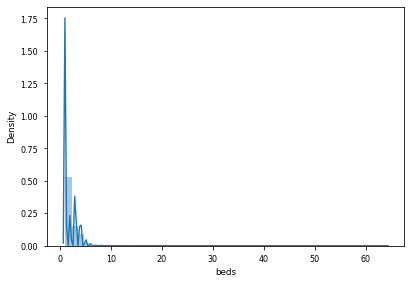

In [798]:
sns.distplot(data_d['beds'])

In [799]:
data_d['beds_big']= data_d['beds'].apply(lambda x: True if x>7 else False)

In [800]:
data_d.beds = data_d.beds.apply(lambda x: 11 if x>10 else x)

<AxesSubplot:xlabel='beds', ylabel='Density'>

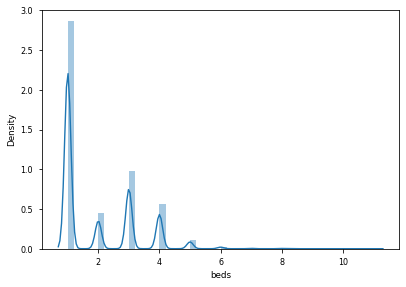

In [801]:
sns.distplot(data_d['beds'])

In [802]:
y = data_d['target']

In [803]:
x = data_d['beds']

Text(0.5, 1.0, 'Зависимость цены от количества комнат')

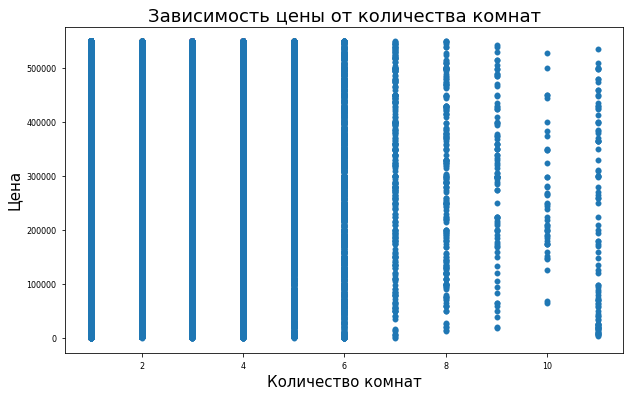

In [804]:
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Количество комнат', fontsize = 15)
plt.ylabel('Цена', fontsize = 15)
plt.title('Зависимость цены от количества комнат', fontsize = 18)


In [805]:
#data_d.plot(y='target',x='beds', kind='line',
#           color='blue',  title='Зависимость цены от города')

<AxesSubplot:xlabel='beds'>

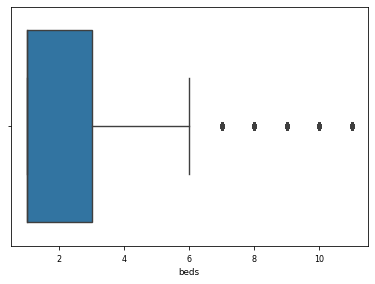

In [806]:
sns.boxplot(data_d['beds'])

# Ванны - приведение к численному виду.

In [807]:
data_d['baths'].unique()   

array(['3.5', '3 Baths', nan, '2', '3', 'Bathrooms: 2', '1,750',
       '4 Baths', '2 ba', '2 Baths', '2.0', '3.0', 'Bathrooms: 1',
       '2.1 Baths', '2.5 Baths', '1', '4.5', 'Bathrooms: 4', '3 ba',
       '4.0', '2,500', '5.5 Baths', '1.0', 'Bathrooms: 3', '1.5', '2.5',
       '4,000', '3.5 Baths', '2,000', '1 ba', '0', '1,500', '2,250',
       '1,000', '3,500', '4', '~', '3,000', '2,750', '750', '5 Baths',
       '1,250', '1.5 Baths', '6 Baths', '0 / 0', '5 ba', '4 ba', '2.5+',
       '6.0', '4.5 Baths', '-- baths', '7', '1.5+', '6', '5,000', '5',
       '8 Baths', 'Bathrooms: 5', '5.5', '19 Baths', '1.75 Baths',
       'Bathrooms: 6', '13 Baths', '5.0', 'Sq. Ft. ', '1.1 Baths',
       '2.5 ba', 'Bathrooms: 12', '3.5+', '7 Baths', 'Bathrooms: 241',
       '8.0', '6.5', '14 Baths', '3.5 ba', '7,500+', '4.5+', '6.5 Baths',
       '1.75 ba', '7 ba', '22.0', '0.00', '2.25 Baths', 'Bathrooms: 7',
       '4.5 ba', '18.0', '10 Baths', '2.75 Baths', '0.0', '10',
       '16 Baths', '7.0', '

Вспомогательная функция извлекает численное значение из текста. Если значение некорректно, выдает 1. Применила здесь, а также для обработки этажей.)

In [808]:
def extract_num_recurr(stroka,first_digit,len_s,i):
    if i == len_s and stroka[i].isdigit():
        return (float(first_digit + str(stroka[i])))
    elif i < len_s and (stroka[i].isdigit() or stroka[i] == '.'):
        return extract_num_recurr(stroka, (first_digit + str(stroka[i])), len_s, i+1)
    
    else: return(float(first_digit))
                        
def extract_num(stroka,len_s,i):
  
    if i == len_s and not stroka[i].isdigit():
        return 1
    elif i == len_s and stroka[i].isdigit():
        return float(stroka[i])
    elif i < len_s and stroka[i].isdigit():
        return extract_num_recurr(stroka,str(stroka[i]),len_s,i+1)
    else: return extract_num(stroka,len_s,i+1)

def main_extract_num(stroka):   
    len_s=len(stroka)-1
    
    return extract_num(stroka,len_s,0)

In [809]:
data_d.baths = data_d.baths.apply(lambda x: round(main_extract_num(str(x)),1))

In [810]:
data_d['baths'].unique()   

array([3.50e+00, 3.00e+00, 1.00e+00, 2.00e+00, 4.00e+00, 2.10e+00,
       2.50e+00, 4.50e+00, 5.50e+00, 1.50e+00, 0.00e+00, 7.50e+02,
       5.00e+00, 6.00e+00, 7.00e+00, 8.00e+00, 1.90e+01, 1.80e+00,
       1.30e+01, 1.10e+00, 1.20e+01, 2.41e+02, 6.50e+00, 1.40e+01,
       2.20e+01, 2.20e+00, 1.80e+01, 1.00e+01, 2.80e+00, 1.60e+01,
       1.10e+01, 1.50e+01, 3.80e+00, 3.20e+00, 9.00e+00, 1.20e+00,
       2.00e+01, 2.50e+01, 5.00e-01, 8.50e+00, 3.10e+00, 3.00e+01,
       8.00e-01, 1.70e+01, 4.10e+00, 2.80e+01])

In [811]:
data_d['baths'].isna().unique()   

array([False])

# Визуализация и обработка признака ванны (baths).

<AxesSubplot:xlabel='baths', ylabel='Density'>

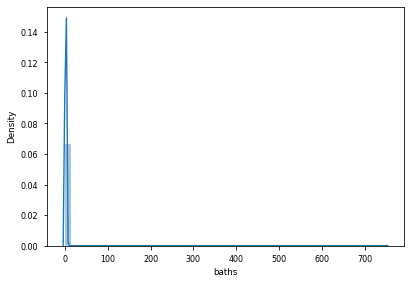

In [812]:
sns.distplot(data_d['baths'])

In [813]:
t = data_d.loc[data_d['baths']>10]

In [814]:
t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 1109 to 376147
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   status          178 non-null    object 
 1   private pool    0 non-null      object 
 2   propertyType    155 non-null    object 
 3   street          179 non-null    object 
 4   baths           179 non-null    float64
 5   homeFacts       179 non-null    object 
 6   fireplace       47 non-null     object 
 7   city            179 non-null    object 
 8   schools         179 non-null    object 
 9   sqft            174 non-null    float64
 10  zipcode         179 non-null    object 
 11  beds            179 non-null    int64  
 12  state           179 non-null    object 
 13  stories         65 non-null     object 
 14  mls-id          4 non-null      object 
 15  PrivatePool     1 non-null      object 
 16  MlsId           173 non-null    object 
 17  target          179 non-null 

In [815]:
data_d = data_d[data_d['baths']<10]

<AxesSubplot:xlabel='baths', ylabel='Density'>

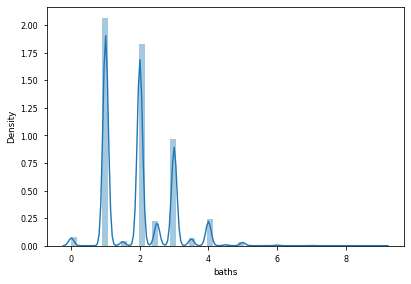

In [816]:
sns.distplot(data_d['baths'])

In [817]:
x = data_d['baths']
y = data_d['target']

Text(0.5, 1.0, 'Зависимость цены от оборудования ванн')

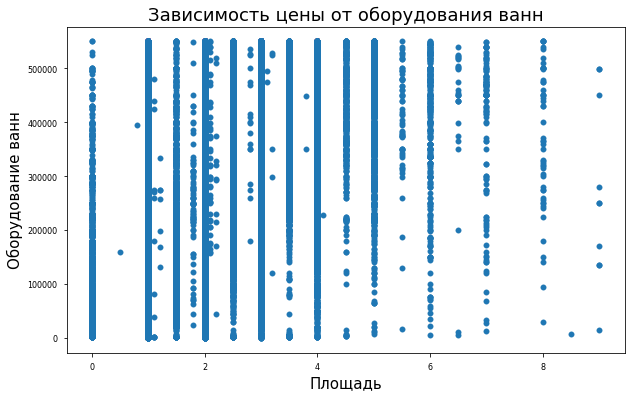

In [818]:
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Площадь', fontsize = 15)
plt.ylabel('Оборудование ванн', fontsize = 15)
plt.title('Зависимость цены от оборудования ванн', fontsize = 18)

 # Камин

Вспомогательная функция для приведения признака числа каминов к численному виду.

In [819]:
def fireplaces_def(stroka):
    if stroka == 'yes': return 1
    elif stroka == 'Yes': return 1
    elif stroka == '1': return 1
    elif stroka == '2': return 2
    else: return 0

In [820]:
data_d['fireplace'].value_counts() 

yes                                                           32532
Yes                                                           13101
1                                                             10500
Not Applicable                                                 1949
2                                                               822
                                                              ...  
Ceiling Fan, Central Vacuum, Intercom, Wet Bar                    1
Gas Logs, In Den/Family Room, In Living Room, Wood Burning        1
7                                                                 1
Great Room, Natural Gas, Wood Burning                             1
Fireplace-Gas, Fireplace-Wood, Patio, Walk-in Closet              1
Name: fireplace, Length: 1029, dtype: int64

In [821]:
data_d.fireplace = data_d.fireplace.apply(lambda x: fireplaces_def(str(x)))


In [822]:
data_d['fireplace'].unique()

array([0, 1, 2])

In [823]:
data_d['fireplace'].isna().unique() 

array([False])

In [824]:
x = data_d['fireplace']
y = data_d['target']

Text(0.5, 1.0, 'Зависимость цены от наличия камина')

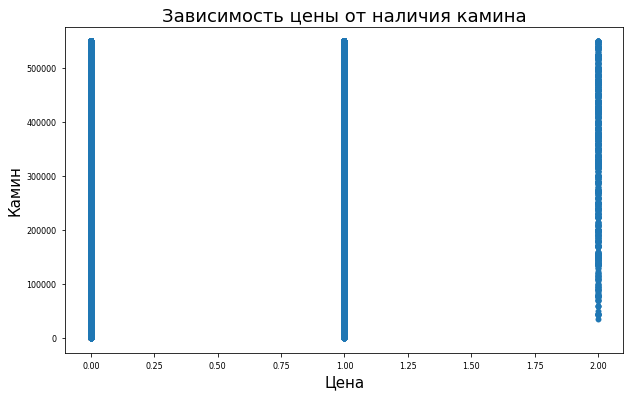

In [825]:
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Цена', fontsize = 15)
plt.ylabel('Камин', fontsize = 15)
plt.title('Зависимость цены от наличия камина', fontsize = 18)

# Бассейн. Анализ.

In [826]:
data_d['private pool'].value_counts()

Yes    2712
Name: private pool, dtype: int64

In [827]:
data_d.loc[data_d['private pool'] == 'Yes']

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,sqft_big,beds_big
205,For sale,Yes,Single Family,1403 Betton Rd,2.0,"[1958, 1980, Heat pump, Central, 1 space, 0.45...",1,Tallahassee,"{'rating': ['4/10', '5/10', '7/10'], 'data': {...",2361.0,32308,3,FL,NaN,302221,NaN,NaN,385000.0,1973,1973,Central Electric,Central Gas,,"7,480 Sq. Ft.",$110 / Sq. Ft.,"['8', '7', '7']","['1.9 mi', '1.7 mi', '1.2 mi']","['Preschool to 5', '6 to 8', '9 to 12']","['Ray Daily Elementary School', 'West Briar Mi...",False,False
321,For sale,Yes,Single Family,3296 Ledgewood Cir,3.0,"[2017, , Forced air, Central, 2 spaces, 3,484 ...",0,Riverside,"{'rating': ['4/10', '4/10', '6/10'], 'data': {...",2135.0,92503,3,CA,2.0,IV19242188,NaN,NaN,525000.0,1955,,,,,"8,190 Sq. Ft.",$81 / Sq. Ft.,"['2', '3', '3']","['0.5 mi', '1.1 mi', '0.3 mi']","['K to 5', '6 to 8', '9 to 12']","['Willow Oaks Elementary School', 'Colonial Mi...",False,False
355,For sale,Yes,Mobile / Manufactured,2250 N Broadway # 42,2.0,"[1976, , Forced air, Central, 2 spaces, -- sqf...",0,Escondido,"{'rating': ['4/10', '4/10', '6/10'], 'data': {...",1536.0,92026,2,CA,0.0,190034991,NaN,NaN,119000.0,,,Forced Air,Central,Attached Garage,5.00 acres,$142/sqft,"['8/10', '9/10', '5/10']","['5.01mi', '5.07mi', '0.23mi']","['6-8', '9-12', 'PK-5']","['Rossview Middle School', 'Rossview High Scho...",False,False
425,Pre-foreclosure / auction,Yes,Single Family,7632 Hillside Dr,2.0,"[1964, 1964, Forced air, Central, , 8,624 sqft, ]",1,Jacksonville,"{'rating': ['5/10', '2/10', '4/10'], 'data': {...",1245.0,32221,3,FL,1.0,NaN,NaN,NaN,128103.0,1959,,Other,Central,Carport,0.27 acres,$104/sqft,"['3/10', '5/10']","['3.64mi', '3.64mi']","['1-5', '6-8']","['Bramlette Elementary School', 'Judson Middle...",False,False
447,For sale,Yes,Single Family,5370 Christie Ann Pl # 17,2.0,"[1992, 1992, Forced air, Central, Attached Gar...",0,Sarasota,"{'rating': ['10/10', '9/10', '6/10'], 'data': ...",1936.0,34233,3,FL,1.0,O5821850,NaN,NaN,258000.0,1986,,Electric Heat,Central Heating,,"3,024 Sq. Ft.",$118 / Sq. Ft.,"['8', '10', '8']","['1.2 mi', '2.8 mi', '1.3 mi']","['Preschool to 5', '6 to 8', '9 to 12']","['Stone Oak Elementary School', 'Bush Middle S...",False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376298,Pre-foreclosure,Yes,Single Family,15369 Daybreak Ln,3.0,"[1990, 2007, Other, Central, 3 spaces, 6,011 s...",1,Fontana,"{'rating': ['4/10', '3/10', '4/10'], 'data': {...",2225.0,92337,5,CA,2.0,NaN,NaN,NaN,399094.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
376340,For sale,Yes,Condo,200 River Vista Dr UNIT 436,2.0,"[2010, , Forced air, Central, Attached Garage,...",0,Atlanta,"{'rating': ['9/10', '6/10', '6/10'], 'data': {...",1299.0,30339,2,GA,1.0,8690633,NaN,NaN,295000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
376582,For sale,Yes,Single Family,3235 Landover Blvd,2.0,"[2005, 2005, Other, Central, 1 space, 10,741 s...",0,Spring Hill,"{'rating': ['4/10', '6/10'], 'data': {'Distanc...",2256.0,34609,4,FL,1.0,2204520,NaN,NaN,225000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
376686,For sale,Yes,Single Family,2609 S Marigold Ave,3.0,"[1979, 1979, Forced air, Central, 2 spaces, 7,...",0,Ontario,"{'rating': ['7/10', '6/10', '5/10'], 'data': {...",1726.0,91761,3,CA,2.0,IV19252050,NaN,NaN,479000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False


Вывод: число домов с бассейнами незначительно (4181 из 377185), разброс цен для домов с бассейнами большой, явного влияния на цену нет. Можно не рассматривать.

 # propertyType

In [828]:
data_d['propertyType'].value_counts(normalize=True)

single-family home                                             0.272630
Single Family                                                  0.180140
Single Family Home                                             0.098087
lot/land                                                       0.070871
condo                                                          0.066419
                                                                 ...   
Penthouse, Low Rise                                            0.000004
Traditional, Loft with Bedrooms                                0.000004
Condo/Townhome, French, Split Level                            0.000004
Traditional, Colonial, Federal                                 0.000004
Bilevel, Converted Dwelling, Loft with Bedrooms, Condo/Unit    0.000004
Name: propertyType, Length: 884, dtype: float64

In [829]:
data_d.propertyType = data_d.propertyType.apply(lambda x: str(x))

In [830]:
data_d.propertyType = data_d.propertyType.apply(lambda x: 'sfh' if x in ['single-family home','Single Family','Single Family Home'] else x)

In [831]:
data_d['propertyType'].value_counts(normalize=True)

sfh                                                            0.503427
nan                                                            0.086101
lot/land                                                       0.064769
condo                                                          0.060700
Condo                                                          0.041319
                                                                 ...   
Penthouse, Low Rise                                            0.000004
Traditional, Loft with Bedrooms                                0.000004
Condo/Townhome, French, Split Level                            0.000004
Traditional, Colonial, Federal                                 0.000004
Bilevel, Converted Dwelling, Loft with Bedrooms, Condo/Unit    0.000004
Name: propertyType, Length: 883, dtype: float64

In [832]:
data_d.propertyType = data_d.propertyType.apply(lambda x: x.lower())

In [833]:
data_d.propertyType = data_d.propertyType.apply(lambda x: 'mlf' if (x.find('multi')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'ctmp' if (x.find('contempor')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'loft' if (x.find('loft')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'twnh' if (x.find('townhouse')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'condo' if (x.find('condo')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'sn_dtch' if (x.find('single detached')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'eng' if (x.find('english')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'other' if x not in ['mlf','ctmp','loft','twnh','condo','sn_dtch','eng'] else x)

In [834]:
data_d['propertyType'].value_counts()

other      214443
condo       34421
twnh        14316
mlf          5946
ctmp         2836
sn_dtch      2261
loft           32
eng            27
Name: propertyType, dtype: int64

Преобразование к численному виду.

In [835]:
data_d['propertyType'] = data_d['propertyType'].astype('category')
data_d['propertyType_cat'] = data_d['propertyType'].cat.codes

In [836]:
data_d['propertyType_cat'].value_counts()

5    214443
0     34421
7     14316
4      5946
1      2836
6      2261
3        32
2        27
Name: propertyType_cat, dtype: int64

In [837]:
data_d['propertyType'].isna().unique() 

array([False])

In [838]:
x = data_d['propertyType_cat']
y = data_d['target']

Text(0.5, 1.0, 'Зависимость цены от типа собственности')

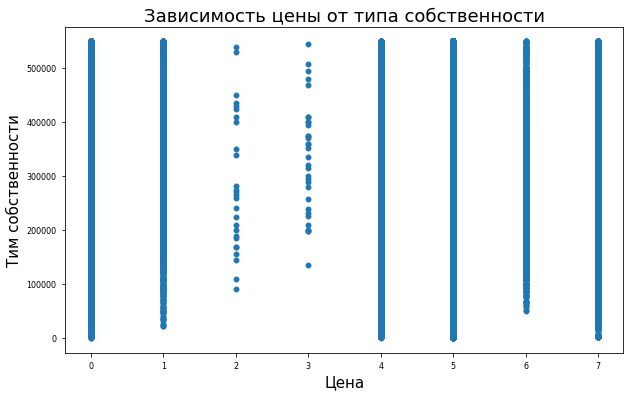

In [839]:
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Цена', fontsize = 15)
plt.ylabel('Тим собственности', fontsize = 15)
plt.title('Зависимость цены от типа собственности', fontsize = 18)

# Город

In [840]:
data_d.city.fillna('others',inplace=True)

In [841]:
data_d['city'].isna().sum()

0

In [842]:
t = data_d['city'].value_counts()

In [843]:
t

Houston         19028
San Antonio     14489
Miami            9997
Jacksonville     9089
Dallas           5778
                ...  
Nashport            1
SUNRISE             1
EVERGREEN           1
Downs               1
Blue Springs        1
Name: city, Length: 1806, dtype: int64

In [844]:
t_df = pd.DataFrame(t)

In [845]:
t_df.loc[t_df['city']==np.NaN]

,city


In [846]:
t_df['city'].isna().sum()

0

In [847]:
dict_t = t_df.to_dict()

In [848]:
dict_city = dict_t.get('city')

In [849]:
data_d['city'].isna().sum()

0

Вспомогательная функция присваивает значение others, если число вхождений данного города невелико. (Здесь меньше 500.)

In [850]:
def other_cities(x1,d):
    if x1==np.NaN:
        return ('others')
    elif d.get(x1)==np.NaN:
        return('others')
    elif d.get(x1)<500: return ('others')
    else: return(x1)


In [851]:
data_d.city = data_d.city.apply(lambda x: other_cities(x,dict_city))

In [852]:
data_d.head(30)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,sqft_big,beds_big,propertyType_cat
0,Active,NaN,other,240 Heather Ln,3.5,"[2019, , Central A/C, Heat Pump, , , None, $144]",0,others,"{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR...",2900.0,28387,1,NC,NaN,NaN,NaN,611019,418000.0,2019,,"Central A/C, Heat Pump",,,None,$144,"['4', '4', '7', 'NR', '4', '7', 'NR', 'NR']","['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10.5...","['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', ...","['Southern Pines Elementary School', 'Southern...",False,False,5
1,for sale,NaN,other,12911 E Heroy Ave,3.0,"[2019, , , , , 5828 sqft, $159/sqft]",0,others,"{'rating': ['4/10', 'None/10', '4/10'], 'data'...",1947.0,99216,3,WA,2.0,NaN,NaN,201916904,310000.0,2019,,,,,5828 sqft,$159/sqft,"['4/10', 'None/10', '4/10']","['1.65mi', '1.32mi', '1.01mi']","['9-12', '3-8', 'PK-8']","['East Valley High School&Extension', 'Eastval...",False,False,5
4,for sale,NaN,other,1524 Kiscoe St,1.0,"[, , , , , 10,019 sqft, None]",0,Palm Bay,"{'rating': ['4/10', '5/10', '5/10'], 'data': {...",NaN,32908,1,FL,NaN,NaN,NaN,861745,5000.0,2006,2006,"Electric, Heat Pump",Central Air,,"4,996 Sq. Ft.",$120 / Sq. Ft.,"['3', '3', '1', 'NR']","['0.8 mi', '8.3 mi', '4.2 mi', '2.0 mi']","['Preschool to 4', 'Preschool to 12', '5 to 8'...","['Palmetto Elementary School', 'Haines City Se...",False,False,5
5,for sale,NaN,twnh,1624 S Newkirk St,1.0,"[1920, , Forced Air, Central, , 680 sqft, $233...",0,Philadelphia,"{'rating': [], 'data': {'Distance': [], 'Grade...",897.0,19145,2,PA,2.0,NaN,NaN,PAPH847006,209000.0,1976,,,,,"8,750 Sq. Ft.",$57 / Sq. Ft.,"['4', '2', '2']","['0.7 mi', '0.4 mi', '2.2 mi']","['Preschool to 5', '6 to 8', '9 to 12']","['Crump Elementary School', 'Hickory Ridge Mid...",False,False,7
6,Active,NaN,other,552 Casanova Ct,1.0,"[2006, 2006, Electric, Heat Pump, Central Air,...",0,others,"{'rating': ['3', '3', '1', 'NR'], 'data': {'Di...",1507.0,34759,1,FL,One,NaN,NaN,S5026943,181500.0,1970,,Forced Air,Central,,124582,$68,"['2', '2', '4', '7', '4', 'NR']","['5.6 mi', '5.6 mi', '6.8 mi', '6.5 mi', '6.8 ...","['PK–4', '5–6', '9–12', 'PK–4', '7–8', '9–12']","['Roosevelt Elementary School', 'Lincoln Inter...",False,False,5
7,Active,NaN,other,6094 Mingle Dr,1.0,"[1976, , , , , 8,750 Sq. Ft., $57 / Sq. Ft.]",0,Memphis,"{'rating': ['4', '2', '2'], 'data': {'Distance...",NaN,38115,1,TN,NaN,NaN,NaN,10063506,68000.0,2019,None,Gas,Central,Attached Garage,"2,056 sqft",$162,"['4/10', '3/10', '2/10']","['0.7 mi', '0.6 mi', '1.9 mi']","['PK-5', '5-8', '9-12']","['Edgewood Elementary School', 'Landrum Middle...",False,False,5
8,Active,NaN,other,11182 Owl Ave,2.0,"[1970, , Forced Air, Central, , 124582, $68]",0,others,"{'rating': ['2', '2', '4', '7', '4', 'NR'], 'd...",3588.0,50401,1,IA,NaN,NaN,NaN,190988,244900.0,2015,2015,Central Electric,Central Gas,,"5,715 Sq. Ft.",$83 / Sq. Ft.,"['6', '3', '6', '1', '5']","['0.4 mi', '0.4 mi', '3.0 mi', '3.2 mi', '7.4 ...","['Preschool to 5', '6 to 8', '6 to 8', '9 to 1...","['Pat Reynolds Elementary School', 'Edwin M We...",False,False,5
9,NaN,NaN,other,8612 Cedar Plains Ln,3.0,"[2019, None, Gas, Central, Attached Garage, 2,...",0,Houston,"{'rating': ['4/10', '3/10', '2/10'], 'data': {...",1930.0,77080,1,TX,2.0,NaN,NaN,73968331,311995.0,1996,1997,Forced Air,Central,"Carport, Attached Garage","10,270 sqft",$185/sqft,"['8/10', '7/10', '7/10']","['2.66mi', '0.92mi', '2.54mi']","['6-8', 'PK-5', '9-12']","['Walter C. Young Middle School', 'Silver Palm...",False,False,5
11,Active,NaN,eng,4222 False Cypress Ln,1.0,"[2015, 2015, Central Electric, Central Gas, , ...",0,Houston,"{'rating': ['6', '3', '6', '1', '5'], 'data': ...",3130.0,77068,1,TX,2,NaN,NaN,5741322,260000.0,1982,1982,Other,Central,2 spaces,"2,130 sqft",$69,"['4/10', '5/10', '7/10']","['0.7 mi', '0.6 mi', '2.9 mi']","['P

In [853]:
data_d.loc[data_d['city']=='others']

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,sqft_big,beds_big,propertyType_cat
0,Active,NaN,other,240 Heather Ln,3.5,"[2019, , Central A/C, Heat Pump, , , None, $144]",0,others,"{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR...",2900.0,28387,1,NC,NaN,NaN,NaN,611019,418000.0,2019,,"Central A/C, Heat Pump",,,None,$144,"['4', '4', '7', 'NR', '4', '7', 'NR', 'NR']","['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10.5...","['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', ...","['Southern Pines Elementary School', 'Southern...",False,False,5
1,for sale,NaN,other,12911 E Heroy Ave,3.0,"[2019, , , , , 5828 sqft, $159/sqft]",0,others,"{'rating': ['4/10', 'None/10', '4/10'], 'data'...",1947.0,99216,3,WA,2.0,NaN,NaN,201916904,310000.0,2019,,,,,5828 sqft,$159/sqft,"['4/10', 'None/10', '4/10']","['1.65mi', '1.32mi', '1.01mi']","['9-12', '3-8', 'PK-8']","['East Valley High School&Extension', 'Eastval...",False,False,5
6,Active,NaN,other,552 Casanova Ct,1.0,"[2006, 2006, Electric, Heat Pump, Central Air,...",0,others,"{'rating': ['3', '3', '1', 'NR'], 'data': {'Di...",1507.0,34759,1,FL,One,NaN,NaN,S5026943,181500.0,1970,,Forced Air,Central,,124582,$68,"['2', '2', '4', '7', '4', 'NR']","['5.6 mi', '5.6 mi', '6.8 mi', '6.5 mi', '6.8 ...","['PK–4', '5–6', '9–12', 'PK–4', '7–8', '9–12']","['Roosevelt Elementary School', 'Lincoln Inter...",False,False,5
8,Active,NaN,other,11182 Owl Ave,2.0,"[1970, , Forced Air, Central, , 124582, $68]",0,others,"{'rating': ['2', '2', '4', '7', '4', 'NR'], 'd...",3588.0,50401,1,IA,NaN,NaN,NaN,190988,244900.0,2015,2015,Central Electric,Central Gas,,"5,715 Sq. Ft.",$83 / Sq. Ft.,"['6', '3', '6', '1', '5']","['0.4 mi', '0.4 mi', '3.0 mi', '3.2 mi', '7.4 ...","['Preschool to 5', '6 to 8', '6 to 8', '9 to 1...","['Pat Reynolds Elementary School', 'Edwin M We...",False,False,5
12,for sale,NaN,other,16373 NW 16th St,3.0,"[1996, 1997, Forced Air, Central, Carport, Att...",0,others,"{'rating': ['8/10', '7/10', '7/10'], 'data': {...",2839.0,33028,4,FL,1.0,NaN,yes,A10767242,525000.0,2008,2009,,,,"5,304 Sq. Ft.",$152 / Sq. Ft.,"['4', 'NR', '3', 'NR']","['0.5 mi', '0.7 mi', '0.5 mi', '1.1 mi']","['Preschool to 5', 'Preschool to 8', '6 to 12'...","['Dillard Elementary School', 'Mount Olivet Se...",False,False,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377140,for sale,NaN,other,6383 Cathedral Dr,1.0,"[, , , , , 3.34 acres, None]",0,others,"{'rating': ['5/10', '5/10', '7/10'], 'data': {...",NaN,28601,1,NC,NaN,NaN,NaN,3525591,41000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,5
377147,Active,NaN,other,1022 Lyndon Station Dr,1.0,"[2020, , , Central Air, Gas (Hot Air), Multi-Z...",0,others,"{'rating': ['8', '4', '7'], 'data': {'Distance...",2058.0,28134,1,NC,NaN,NaN,NaN,3576461,342969.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,5
377161,Active,NaN,other,Homestead Dr Lot 1,1.0,"[, , , , , 1, None]",0,others,"{'rating': ['8', '9', '8', 'NR'], 'data': {'Di...",NaN,44408,1,OH,NaN,NaN,NaN,3382834,45000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,5
377173,for sale,NaN,other,19743 N Sagamore Rd,3.0,"[1950, 2010, Forced Air, Central, Detached Gar...",1,others,"{'rating': ['6/10', '5/10', '6/10'], 'data': {...",2505.0,44126,5,OH,2.0,NaN,NaN,4126112,384900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,5


In [854]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)

In [855]:
ohe_ftrs = ohe.fit_transform(data_d['city'].values.reshape(-1,1))

In [856]:
tmp = pd.DataFrame(ohe_ftrs, columns = ['city=' + str(i) for i in range(ohe_ftrs.shape[1])])
data_d = pd.concat([data_d, tmp], axis=1)


In [857]:
data_d.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,sqft_big,beds_big,propertyType_cat,city=0,city=1,city=2,city=3,city=4,city=5,city=6,city=7,city=8,city=9,city=10,city=11,city=12,city=13,city=14,city=15,city=16,city=17,city=18,city=19,city=20,city=21,city=22,city=23,city=24,city=25,city=26,city=27,city=28,city=29,city=30,city=31,city=32,city=33,city=34,city=35,city=36,city=37,city=38,city=39,city=40,city=41,city=42,city=43,city=44,city=45,city=46,city=47,city=48,city=49,city=50,city=51,city=52,city=53,city=54,city=55,city=56,city=57,city=58,city=59,city=60,city=61,city=62,city=63,city=64,city=65,city=66,city=67,city=68,city=69,city=70,city=71,city=72,city=73,city=74,city=75,city=76,city=77,city=78,city=79,city=80,city=81,city=82,city=83,city=84,city=85,city=86,city=87,city=88,city=89,city=90,city=91,city=92,city=93,city=94,city=95,city=96,city=97,city=98,city=99,city=100,city=101,city=102
0,Active,NaN,other,240 Heather Ln,3.5,"[2019, , Central A/C, Heat Pump, , , None, $144]",0.0,others,"{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR...",2900.0,28387,1.0,NC,NaN,NaN,NaN,611019,418000.0,2019,,"Central A/C, Heat Pump",,,None,$144,"['4', '4', '7', 'NR', '4', '7', 'NR', 'NR']","['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10.5...","['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', ...","['Southern Pines Elementary School', 'Southern...",False,False,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,for sale,NaN,other,12911 E Heroy Ave,3.0,"[2019, , , , , 5828 sqft, $159/sqft]",0.0,others,"{'rating': ['4/10', 'None/10', '4/10'], 'data'...",1947.0,99216,3.0,WA,2.0,NaN,NaN,201916904,310000.0,2019,,,,,5828 sqft,$159/sqft,"['4/10', 'None/10', '4/10']","['1.65mi', '1.32mi', '1.01mi']","['9-12', '3-8', 'PK-8']","['East Valley High School&Extension', 'Eastval...",False,False,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,for sale,NaN,other,1524 Kiscoe St,1.0,"[, , , , , 10,019 sqft, None]",0.0,Palm Bay,"{'rating': ['4/10', '5/10', '5/10'], 'data': {...",NaN,32908,1.0,FL,Na

In [858]:
#data_d['city'] = data_d['city'].astype('category')
#data_d['city_cat'] = data_d['city'].cat.codes

In [859]:
#data_d['city_cat'].value_counts()

In [860]:
#sns.distplot(data_d['city_cat'])

In [861]:
#data_d['city_cat'].isna().unique()

In [862]:
#x = data_d['city_cat']
#

In [863]:
#plt.figure(figsize = (10,6))
#plt.scatter(x, y)


# добавим подписи
#plt.xlabel('Площадь', fontsize = 15)
#plt.ylabel('Город', fontsize = 15)
#plt.title('Зависимость цены от города', fontsize = 18)

# Штат

In [864]:
data_d['state'].value_counts()

FL    89739
TX    68170
NC    17930
TN    15040
OH    11473
CA     8584
WA     7759
NY     7683
IL     7081
NV     6511
GA     5043
MI     4913
PA     4705
CO     4335
AZ     3084
IN     3029
DC     1802
OR     1734
UT      906
MO      780
VT      766
MD      759
MA      543
VA      507
WI      389
NJ      318
ME      250
IA      234
KY       86
OK       49
MS       38
SC       26
MT        7
DE        4
Fl        1
BA        1
AL        1
OT        1
OS        1
Name: state, dtype: int64

In [865]:
data_d['state'] = data_d['state'].astype('category')
data_d['state_cat'] = data_d['state'].cat.codes

In [866]:
data_d['state_cat'].value_counts()

 7     89739
-1     74946
 33    68170
 21    17930
 32    15040
 25    11473
 3      8584
 37     7759
 24     7683
 11     7081
 23     6511
 9      5043
 17     4913
 30     4705
 4      4335
 1      3084
 12     3029
 5      1802
 27     1734
 34      906
 18      780
 36      766
 15      759
 14      543
 35      507
 38      389
 22      318
 16      250
 10      234
 13       86
 26       49
 19       38
 31       26
 20        7
 6         4
 8         1
 2         1
 0         1
 29        1
 28        1
Name: state_cat, dtype: int64

In [867]:
data_d['state_cat'].isna().unique()

array([False])

In [868]:
x = data_d['state_cat']
y = data_d['target']

Text(0.5, 1.0, 'Зависимость цены от штата')

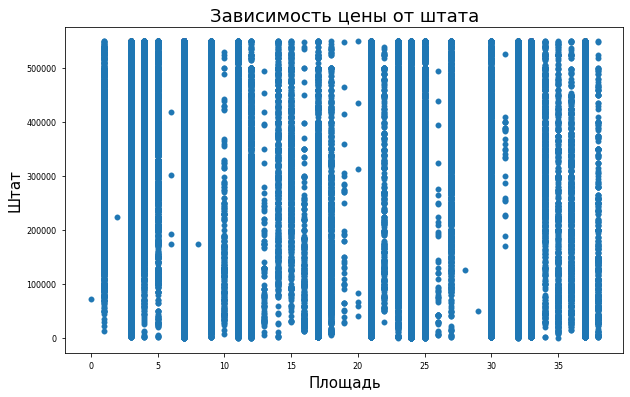

In [869]:
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Площадь', fontsize = 15)
plt.ylabel('Штат', fontsize = 15)
plt.title('Зависимость цены от штата', fontsize = 18)

# Улица

In [870]:
data_d['street'].nunique()

245863

Уникальных значений улиц слишком много. Признак удалила.

 # Stories (надеюсь, это этажи)

In [871]:
data_d['stories'].value_counts()

1.0                   56205
2.0                   38728
1                     19581
2                     12276
3.0                    6183
                      ...  
5.00                      1
A Frame                   1
2 Story, Tri Level        1
42                        1
Patio Home                1
Name: stories, Length: 272, dtype: int64

In [872]:
data_d.stories = data_d.stories.apply(lambda x: main_extract_num(str(x)))


In [873]:
data_d['stories'].value_counts()

1.00       269509
2.00        55538
3.00         9334
0.00         7707
9.00         2070
4.00         1655
1.50         1144
6.00          638
5.00          477
8.00          222
7.00          210
2.50          142
16.00          52
12.00          43
15.00          38
11.00          36
10.00          33
17.00          32
13.00          31
20.00          30
14.00          27
1.75           25
25.00          22
21.00          21
1.70           17
18.00          17
27.00          16
19.00          14
23.00          14
22.00          14
26.00          12
24.00          12
29.00           8
43.00           8
32.00           6
28.00           6
42.00           4
33.00           4
36.00           4
31.00           4
49.00           3
47.00           3
30.00           3
48.00           2
46.00           2
56.00           2
57.00           2
35.00           2
1.30            2
1002.00         1
3.50            1
2.20            1
41.00           1
55.00           1
1120.00         1
40.00     

In [874]:
data_d['stories'].isna().unique()

array([False])

<AxesSubplot:xlabel='stories', ylabel='Density'>

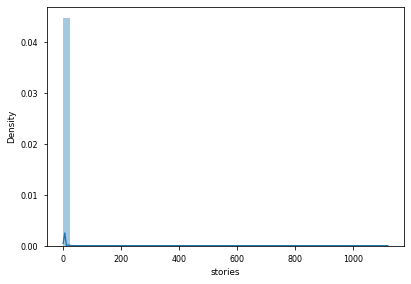

In [875]:
sns.distplot(data_d['stories'])

In [876]:
data_d.loc[data_d['stories']>17].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243 entries, 612 to 375325
Columns: 136 entries, status to state_cat
dtypes: category(2), float64(110), int8(1), object(23)
memory usage: 256.8+ KB


In [877]:
data_d = data_d[data_d['stories']<17]

In [878]:
x = data_d['stories']
y = data_d['target']

Text(0.5, 1.0, 'Зависимость цены от этажа')

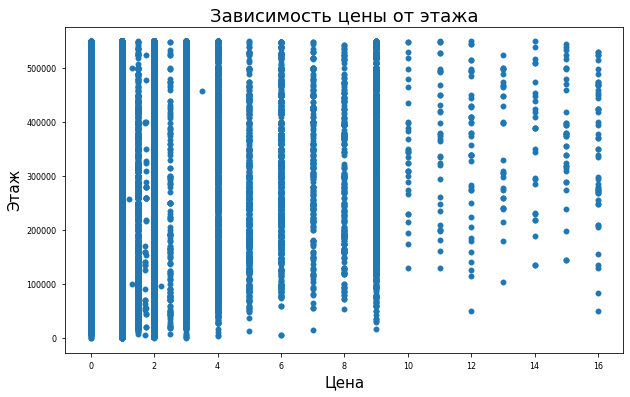

In [879]:
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Цена', fontsize = 15)
plt.ylabel('Этаж', fontsize = 15)
plt.title('Зависимость цены от этажа', fontsize = 18)

 # Status

In [880]:
data_d['status'].value_counts()

for sale                113218
Active                   76591
For sale                 30301
foreclosure               5150
Pending                   4054
                         ...  
Contingent   No Show         1
Pending Sale                 1
Coming soon: Nov 30.         1
Coming soon: Dec 16.         1
Accepting backups            1
Name: status, Length: 149, dtype: int64

In [881]:
data_d.status = data_d.status.apply(lambda x: 'for_sale' if x in ['for sale','For sale'] else x)

In [882]:
data_d.status = data_d.status.apply(lambda x: str(x))

In [883]:
data_d.status = data_d.status.apply(lambda x: x.lower())

In [884]:
data_d.status = data_d.status.apply(lambda x: 'actv' if (x.find('activ')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'cnstr' if (x.find('construction')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'cntrct' if (x.find('contract')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'frcls' if (x.find('foreclosure')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'pnd' if (x.find('pending')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'cntgs' if (x.find('contingen')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'cmg_s' if (x.find('coming soon')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'frcls' if (x.find('foreclosure')>-1) else x)

In [885]:
data_d['status'].unique()

array(['actv', 'for_sale', 'nan', 'cnstr', 'pnd', ' / auction', 'cntrct',
       'frcls', 'p', 'foreclosed', 'for rent', 'auction', 'cntgs',
       'price change', 'back on market', 'new', 'cmg_s', 'pf',
       'apartment for rent', 'pi', 'due diligence period',
       'c continue show', 'for sale', 'c', 'condo for rent', 'ct',
       'accepted offer', 'closed', 'listing extended',
       'conting accpt backups', 'lease/purchase', 'ps',
       'uc continue to show', 'backup', 'accepting backups'], dtype=object)

In [886]:
data_d['status'].value_counts()

for_sale                 143519
nan                      104354
actv                      77419
frcls                      8468
pnd                        4624
cnstr                      3385
cntrct                     2593
cntgs                       935
p                           781
 / auction                  556
auction                     458
new                         454
price change                408
for rent                    396
foreclosed                  288
back on market              101
cmg_s                        78
pi                           29
due diligence period         26
c continue show              18
c                            18
listing extended              8
apartment for rent            7
condo for rent                7
accepted offer                4
closed                        4
pf                            3
ct                            3
ps                            2
uc continue to show           2
for sale                      1
conting 

Приведение к численному виду.

In [887]:
data_d['status'] = data_d['status'].astype('category')
data_d['status_cat'] = data_d['status'].cat.codes

In [888]:
data_d['status'].isna().unique()

array([False])

In [889]:
x = data_d['status_cat']
y = data_d['target']


Text(0.5, 1.0, 'Зависимость цены от статуса продажи')

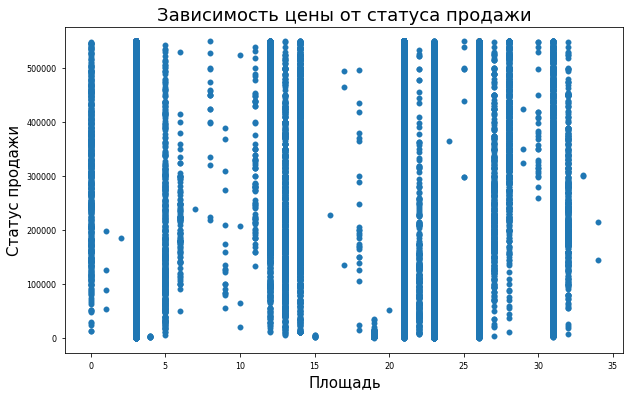

In [890]:
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Площадь', fontsize = 15)
plt.ylabel('Статус продажи', fontsize = 15)
plt.title('Зависимость цены от статуса продажи', fontsize = 18)

# Индекс

In [891]:
data_d['zipcode'].value_counts()

32137         1826
78245         1381
34759         1321
78253         1266
78254         1228
              ... 
27705-3530       1
27603-5569       1
50439            1
47901            1
44704            1
Name: zipcode, Length: 4269, dtype: int64

In [892]:
data_d.zipcode = data_d.zipcode.apply(lambda x: (str(x))[0:2])

In [893]:
#data_d.zipcode = data_d.zipcode.apply(lambda x: float(x))

In [894]:
data_d['zipcode'].value_counts()

na    74946
33    51202
77    25825
32    24558
78    21004
      ...  
0         2
35        1
58        1
--        1
00        1
Name: zipcode, Length: 79, dtype: int64

In [895]:
data_d['zipcode'].isna().unique()

array([False])

In [896]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 348953 entries, 0 to 377184
Columns: 137 entries, status to status_cat
dtypes: category(3), float64(110), int8(2), object(22)
memory usage: 355.8+ MB


# Обработка признака homeFacts.

Вспомогательная функция для извлечения списка значимых величин из признака. (Извлекает список словарей из исходной структуры, которая тоже является словарем. Затем по ключевым словам словаря формирует список значимых величин. Возвращает нан, если в списке отсутствует ключевое слово основного словаря.)

In [897]:
#def facts_extraction(slovar):
#    if slovar.find('atAGlanceFacts')>-1:
#        slovar1 = eval(slovar)
#       # print(type(slovar1))
#        #print(slovar1)
#        slovar2=slovar1.get('atAGlanceFacts')
#       # print(type(slovar2))
#       # print(slovar2)
#        
#        lst = ['']
#        for i in slovar2:
#            
#            lst.append(i.get('factValue'))
#        lst_res=lst[1:]
#        return lst_res
#            
#    else: return np.NaN

In [898]:
#data_d.homeFacts = data_d.homeFacts.apply(lambda x: facts_extraction(x))

In [899]:
#t = data_d['homeFacts']
#t

In [900]:
#t_lst = t.tolist()

In [901]:
#columns = ['Year built','Remodeled year','Heating','Cooling','Parking','lotsize','price_sqft']

In [902]:
#t1 = pd.DataFrame(t_lst, columns = columns)

In [903]:
#data_d = data_d.join(t1)

In [904]:
#data_d.head(3)

In [905]:
#data_d['price_sqft'].unique()

# Обработка признака школы

In [906]:
#data_d.schools = data_d.schools.apply(lambda x: eval(x[1:-1]))

In [907]:
#t = data_d['schools']
#t

In [908]:
#t_lst = t.tolist()

In [909]:
#t5_lst = []
#for i in t_lst:
#    i1 = dict([('rating', i.get('rating')), ('Distance', (i.get('data')).get('Distance')), ('Grades', (i.get('data')).get('Grades')),('name',i.get('name'))])
#    t5_lst.append(i1)

In [910]:
#df_lst = pd.DataFrame(t5_lst,dtype=str)

In [911]:
#df_lst.head(10)

In [912]:
#data_d = data_d.join(df_lst)

# Разбор нового признака - рейтинг школы

Вспомогательная функция - возвращает численный список: численное значение рейтинга, если рейтинг выражен числом, первое значение дроби или ноль, если встречаются любые другие символы.

In [913]:
data_d['typeRating']=data_d['rating'].apply(lambda x: type(x))

In [914]:
data_d['typeRating'].value_counts()

<class 'str'>      199266
<class 'float'>    149687
Name: typeRating, dtype: int64

In [915]:
data_d.rating=data_d.rating.apply(lambda x: '[]' if type(x)==float else x)

In [916]:
data_d.head(4)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,sqft_big,beds_big,propertyType_cat,city=0,city=1,city=2,city=3,city=4,city=5,city=6,city=7,city=8,city=9,city=10,city=11,city=12,city=13,city=14,city=15,city=16,city=17,city=18,city=19,city=20,city=21,city=22,city=23,city=24,city=25,city=26,city=27,city=28,city=29,city=30,city=31,city=32,city=33,city=34,city=35,city=36,city=37,city=38,city=39,city=40,city=41,city=42,city=43,city=44,city=45,city=46,city=47,city=48,city=49,city=50,city=51,city=52,city=53,city=54,city=55,city=56,city=57,city=58,city=59,city=60,city=61,city=62,city=63,city=64,city=65,city=66,city=67,city=68,city=69,city=70,city=71,city=72,city=73,city=74,city=75,city=76,city=77,city=78,city=79,city=80,city=81,city=82,city=83,city=84,city=85,city=86,city=87,city=88,city=89,city=90,city=91,city=92,city=93,city=94,city=95,city=96,city=97,city=98,city=99,city=100,city=101,city=102,state_cat,status_cat,typeRating
0,actv,NaN,other,240 Heather Ln,3.5,"[2019, , Central A/C, Heat Pump, , , None, $144]",0.0,others,"{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR...",2900.0,28,1.0,NC,1.0,NaN,NaN,611019,418000.0,2019,,"Central A/C, Heat Pump",,,None,$144,"['4', '4', '7', 'NR', '4', '7', 'NR', 'NR']","['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10.5...","['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', ...","['Southern Pines Elementary School', 'Southern...",False,False,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,21,3,<class 'str'>
1,for_sale,NaN,other,12911 E Heroy Ave,3.0,"[2019, , , , , 5828 sqft, $159/sqft]",0.0,others,"{'rating': ['4/10', 'None/10', '4/10'], 'data'...",1947.0,99,3.0,WA,2.0,NaN,NaN,201916904,310000.0,2019,,,,,5828 sqft,$159/sqft,"['4/10', 'None/10', '4/10']","['1.65mi', '1.32mi', '1.01mi']","['9-12', '3-8', 'PK-8']","['East Valley High School&Extension', 'Eastval...",False,False,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,37,21,<class 'str'>
2,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,na,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,26,<class 'float'>
3,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,na,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,26,<class 'float'>


In [917]:
data_d.rating=data_d.rating.apply(lambda x: eval(x))

In [918]:
data_d.head(4)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,sqft_big,beds_big,propertyType_cat,city=0,city=1,city=2,city=3,city=4,city=5,city=6,city=7,city=8,city=9,city=10,city=11,city=12,city=13,city=14,city=15,city=16,city=17,city=18,city=19,city=20,city=21,city=22,city=23,city=24,city=25,city=26,city=27,city=28,city=29,city=30,city=31,city=32,city=33,city=34,city=35,city=36,city=37,city=38,city=39,city=40,city=41,city=42,city=43,city=44,city=45,city=46,city=47,city=48,city=49,city=50,city=51,city=52,city=53,city=54,city=55,city=56,city=57,city=58,city=59,city=60,city=61,city=62,city=63,city=64,city=65,city=66,city=67,city=68,city=69,city=70,city=71,city=72,city=73,city=74,city=75,city=76,city=77,city=78,city=79,city=80,city=81,city=82,city=83,city=84,city=85,city=86,city=87,city=88,city=89,city=90,city=91,city=92,city=93,city=94,city=95,city=96,city=97,city=98,city=99,city=100,city=101,city=102,state_cat,status_cat,typeRating
0,actv,NaN,other,240 Heather Ln,3.5,"[2019, , Central A/C, Heat Pump, , , None, $144]",0.0,others,"{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR...",2900.0,28,1.0,NC,1.0,NaN,NaN,611019,418000.0,2019,,"Central A/C, Heat Pump",,,None,$144,"[4, 4, 7, NR, 4, 7, NR, NR]","['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10.5...","['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', ...","['Southern Pines Elementary School', 'Southern...",False,False,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,21,3,<class 'str'>
1,for_sale,NaN,other,12911 E Heroy Ave,3.0,"[2019, , , , , 5828 sqft, $159/sqft]",0.0,others,"{'rating': ['4/10', 'None/10', '4/10'], 'data'...",1947.0,99,3.0,WA,2.0,NaN,NaN,201916904,310000.0,2019,,,,,5828 sqft,$159/sqft,"[4/10, None/10, 4/10]","['1.65mi', '1.32mi', '1.01mi']","['9-12', '3-8', 'PK-8']","['East Valley High School&Extension', 'Eastval...",False,False,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,37,21,<class 'str'>
2,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,na,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,26,<class 'float'>
3,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,na,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,26,<class 'float'>


In [919]:
def school_rating1 (lst_r):
    lst_clean = []
    for p in lst_r:
        if p.find('/') == -1:
            if p.isdigit():
                lst_clean.append(int(p))
            else: lst_clean.append(0)
        else:
            num = p[:p.find('/')]
            if num.isdigit():
                lst_clean.append(int(num))
                
            else: lst_clean.append(0)

    return lst_clean

In [920]:
data_d.rating = data_d.rating.apply(lambda x: school_rating1(x))

In [921]:
data_d.head(2)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,sqft_big,beds_big,propertyType_cat,city=0,city=1,city=2,city=3,city=4,city=5,city=6,city=7,city=8,city=9,city=10,city=11,city=12,city=13,city=14,city=15,city=16,city=17,city=18,city=19,city=20,city=21,city=22,city=23,city=24,city=25,city=26,city=27,city=28,city=29,city=30,city=31,city=32,city=33,city=34,city=35,city=36,city=37,city=38,city=39,city=40,city=41,city=42,city=43,city=44,city=45,city=46,city=47,city=48,city=49,city=50,city=51,city=52,city=53,city=54,city=55,city=56,city=57,city=58,city=59,city=60,city=61,city=62,city=63,city=64,city=65,city=66,city=67,city=68,city=69,city=70,city=71,city=72,city=73,city=74,city=75,city=76,city=77,city=78,city=79,city=80,city=81,city=82,city=83,city=84,city=85,city=86,city=87,city=88,city=89,city=90,city=91,city=92,city=93,city=94,city=95,city=96,city=97,city=98,city=99,city=100,city=101,city=102,state_cat,status_cat,typeRating
0,actv,NaN,other,240 Heather Ln,3.5,"[2019, , Central A/C, Heat Pump, , , None, $144]",0.0,others,"{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR...",2900.0,28,1.0,NC,1.0,NaN,NaN,611019,418000.0,2019,,"Central A/C, Heat Pump",,,None,$144,"[4, 4, 7, 0, 4, 7, 0, 0]","['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10.5...","['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', ...","['Southern Pines Elementary School', 'Southern...",False,False,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,21,3,<class 'str'>
1,for_sale,NaN,other,12911 E Heroy Ave,3.0,"[2019, , , , , 5828 sqft, $159/sqft]",0.0,others,"{'rating': ['4/10', 'None/10', '4/10'], 'data'...",1947.0,99,3.0,WA,2.0,NaN,NaN,201916904,310000.0,2019,,,,,5828 sqft,$159/sqft,"[4, 0, 4]","['1.65mi', '1.32mi', '1.01mi']","['9-12', '3-8', 'PK-8']","['East Valley High School&Extension', 'Eastval...",False,False,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,37,21,<class 'str'>


# Создание новых признаков: маскимальный рейтинг, средний рейтинг.

In [922]:
data_d['max_rating'] = data_d['rating'].apply(lambda x: 0 if x == [] else max(x))

In [923]:
data_d['mean_rating'] = data_d['rating'].apply(lambda x: 0 if x == [] else round(sum(x)/len(x),2))

In [924]:
data_d.head(3)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,sqft_big,beds_big,propertyType_cat,city=0,city=1,city=2,city=3,city=4,city=5,city=6,city=7,city=8,city=9,city=10,city=11,city=12,city=13,city=14,city=15,city=16,city=17,city=18,city=19,city=20,city=21,city=22,city=23,city=24,city=25,city=26,city=27,city=28,city=29,city=30,city=31,city=32,city=33,city=34,city=35,city=36,city=37,city=38,city=39,city=40,city=41,city=42,city=43,city=44,city=45,city=46,city=47,city=48,city=49,city=50,city=51,city=52,city=53,city=54,city=55,city=56,city=57,city=58,city=59,city=60,city=61,city=62,city=63,city=64,city=65,city=66,city=67,city=68,city=69,city=70,city=71,city=72,city=73,city=74,city=75,city=76,city=77,city=78,city=79,city=80,city=81,city=82,city=83,city=84,city=85,city=86,city=87,city=88,city=89,city=90,city=91,city=92,city=93,city=94,city=95,city=96,city=97,city=98,city=99,city=100,city=101,city=102,state_cat,status_cat,typeRating,max_rating,mean_rating
0,actv,NaN,other,240 Heather Ln,3.5,"[2019, , Central A/C, Heat Pump, , , None, $144]",0.0,others,"{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR...",2900.0,28,1.0,NC,1.0,NaN,NaN,611019,418000.0,2019,,"Central A/C, Heat Pump",,,None,$144,"[4, 4, 7, 0, 4, 7, 0, 0]","['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10.5...","['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', ...","['Southern Pines Elementary School', 'Southern...",False,False,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,21,3,<class 'str'>,7,3.25
1,for_sale,NaN,other,12911 E Heroy Ave,3.0,"[2019, , , , , 5828 sqft, $159/sqft]",0.0,others,"{'rating': ['4/10', 'None/10', '4/10'], 'data'...",1947.0,99,3.0,WA,2.0,NaN,NaN,201916904,310000.0,2019,,,,,5828 sqft,$159/sqft,"[4, 0, 4]","['1.65mi', '1.32mi', '1.01mi']","['9-12', '3-8', 'PK-8']","['East Valley High School&Extension', 'Eastval...",False,False,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,37,21,<class 'str'>,4,2.67
2,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,na,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,26,<class 'float'>,0,0.00


# Разбор нового признака расстояние

Вспомогательная функция возвращает список числовых значений расстояния

In [925]:
data_d.Distance=data_d.Distance.apply(lambda x: '[]' if type(x)==float else x)

In [926]:
data_d['type_Dist'] = data_d['Distance'].apply(lambda x: type(x))

In [927]:
data_d['type_Dist'].value_counts()

<class 'str'>    348953
Name: type_Dist, dtype: int64

In [928]:
data_d.Distance = data_d.Distance.apply(lambda x: eval(x))

In [929]:
data_d['type_Dist'] = data_d['Distance'].apply(lambda x: type(x))

In [930]:
data_d.head(4)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,sqft_big,beds_big,propertyType_cat,city=0,city=1,city=2,city=3,city=4,city=5,city=6,city=7,city=8,city=9,city=10,city=11,city=12,city=13,city=14,city=15,city=16,city=17,city=18,city=19,city=20,city=21,city=22,city=23,city=24,city=25,city=26,city=27,city=28,city=29,city=30,city=31,city=32,city=33,city=34,city=35,city=36,city=37,city=38,city=39,city=40,city=41,city=42,city=43,city=44,city=45,city=46,city=47,city=48,city=49,city=50,city=51,city=52,city=53,city=54,city=55,city=56,city=57,city=58,city=59,city=60,city=61,city=62,city=63,city=64,city=65,city=66,city=67,city=68,city=69,city=70,city=71,city=72,city=73,city=74,city=75,city=76,city=77,city=78,city=79,city=80,city=81,city=82,city=83,city=84,city=85,city=86,city=87,city=88,city=89,city=90,city=91,city=92,city=93,city=94,city=95,city=96,city=97,city=98,city=99,city=100,city=101,city=102,state_cat,status_cat,typeRating,max_rating,mean_rating,type_Dist
0,actv,NaN,other,240 Heather Ln,3.5,"[2019, , Central A/C, Heat Pump, , , None, $144]",0.0,others,"{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR...",2900.0,28,1.0,NC,1.0,NaN,NaN,611019,418000.0,2019,,"Central A/C, Heat Pump",,,None,$144,"[4, 4, 7, 0, 4, 7, 0, 0]","[2.7 mi, 3.6 mi, 5.1 mi, 4.0 mi, 10.5 mi, 12.6...","['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', ...","['Southern Pines Elementary School', 'Southern...",False,False,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,21,3,<class 'str'>,7,3.25,<class 'list'>
1,for_sale,NaN,other,12911 E Heroy Ave,3.0,"[2019, , , , , 5828 sqft, $159/sqft]",0.0,others,"{'rating': ['4/10', 'None/10', '4/10'], 'data'...",1947.0,99,3.0,WA,2.0,NaN,NaN,201916904,310000.0,2019,,,,,5828 sqft,$159/sqft,"[4, 0, 4]","[1.65mi, 1.32mi, 1.01mi]","['9-12', '3-8', 'PK-8']","['East Valley High School&Extension', 'Eastval...",False,False,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,37,21,<class 'str'>,4,2.67,<class 'list'>
2,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,na,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],[],NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,26,<class 'float'>,0,0.00,<class 'list'>
3,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,na,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],[],NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,26,<class 'float'>

In [931]:
data_d['typeRating'].value_counts()

<class 'str'>      199266
<class 'float'>    149687
Name: typeRating, dtype: int64

In [932]:
def distance_select(distance):
    lst_dist = []
    if distance == []: return []
    else:
        for i in distance:
            if i.find(' mi')>-1:
                lst_dist.append(float(i[:-3]))
            elif i.find('mi')>-1:
                lst_dist.append(float(i[:-2]))
            else: lst_dist.append(0)
    return lst_dist

In [933]:
data_d.Distance = data_d.Distance.apply(lambda x: distance_select(x))

In [934]:
data_d.head(4)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,sqft_big,beds_big,propertyType_cat,city=0,city=1,city=2,city=3,city=4,city=5,city=6,city=7,city=8,city=9,city=10,city=11,city=12,city=13,city=14,city=15,city=16,city=17,city=18,city=19,city=20,city=21,city=22,city=23,city=24,city=25,city=26,city=27,city=28,city=29,city=30,city=31,city=32,city=33,city=34,city=35,city=36,city=37,city=38,city=39,city=40,city=41,city=42,city=43,city=44,city=45,city=46,city=47,city=48,city=49,city=50,city=51,city=52,city=53,city=54,city=55,city=56,city=57,city=58,city=59,city=60,city=61,city=62,city=63,city=64,city=65,city=66,city=67,city=68,city=69,city=70,city=71,city=72,city=73,city=74,city=75,city=76,city=77,city=78,city=79,city=80,city=81,city=82,city=83,city=84,city=85,city=86,city=87,city=88,city=89,city=90,city=91,city=92,city=93,city=94,city=95,city=96,city=97,city=98,city=99,city=100,city=101,city=102,state_cat,status_cat,typeRating,max_rating,mean_rating,type_Dist
0,actv,NaN,other,240 Heather Ln,3.5,"[2019, , Central A/C, Heat Pump, , , None, $144]",0.0,others,"{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR...",2900.0,28,1.0,NC,1.0,NaN,NaN,611019,418000.0,2019,,"Central A/C, Heat Pump",,,None,$144,"[4, 4, 7, 0, 4, 7, 0, 0]","[2.7, 3.6, 5.1, 4.0, 10.5, 12.6, 2.7, 3.1]","['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', ...","['Southern Pines Elementary School', 'Southern...",False,False,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,21,3,<class 'str'>,7,3.25,<class 'list'>
1,for_sale,NaN,other,12911 E Heroy Ave,3.0,"[2019, , , , , 5828 sqft, $159/sqft]",0.0,others,"{'rating': ['4/10', 'None/10', '4/10'], 'data'...",1947.0,99,3.0,WA,2.0,NaN,NaN,201916904,310000.0,2019,,,,,5828 sqft,$159/sqft,"[4, 0, 4]","[1.65, 1.32, 1.01]","['9-12', '3-8', 'PK-8']","['East Valley High School&Extension', 'Eastval...",False,False,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,37,21,<class 'str'>,4,2.67,<class 'list'>
2,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,na,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],[],NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,26,<class 'float'>,0,0.00,<class 'list'>
3,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,na,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],[],NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,26,<class 'float'>,0,0.00,<clas

# Выделение нового признака - цена за квадратный метр.

In [935]:
data_d.head(3)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,sqft_big,beds_big,propertyType_cat,city=0,city=1,city=2,city=3,city=4,city=5,city=6,city=7,city=8,city=9,city=10,city=11,city=12,city=13,city=14,city=15,city=16,city=17,city=18,city=19,city=20,city=21,city=22,city=23,city=24,city=25,city=26,city=27,city=28,city=29,city=30,city=31,city=32,city=33,city=34,city=35,city=36,city=37,city=38,city=39,city=40,city=41,city=42,city=43,city=44,city=45,city=46,city=47,city=48,city=49,city=50,city=51,city=52,city=53,city=54,city=55,city=56,city=57,city=58,city=59,city=60,city=61,city=62,city=63,city=64,city=65,city=66,city=67,city=68,city=69,city=70,city=71,city=72,city=73,city=74,city=75,city=76,city=77,city=78,city=79,city=80,city=81,city=82,city=83,city=84,city=85,city=86,city=87,city=88,city=89,city=90,city=91,city=92,city=93,city=94,city=95,city=96,city=97,city=98,city=99,city=100,city=101,city=102,state_cat,status_cat,typeRating,max_rating,mean_rating,type_Dist
0,actv,NaN,other,240 Heather Ln,3.5,"[2019, , Central A/C, Heat Pump, , , None, $144]",0.0,others,"{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR...",2900.0,28,1.0,NC,1.0,NaN,NaN,611019,418000.0,2019,,"Central A/C, Heat Pump",,,None,$144,"[4, 4, 7, 0, 4, 7, 0, 0]","[2.7, 3.6, 5.1, 4.0, 10.5, 12.6, 2.7, 3.1]","['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', ...","['Southern Pines Elementary School', 'Southern...",False,False,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,21,3,<class 'str'>,7,3.25,<class 'list'>
1,for_sale,NaN,other,12911 E Heroy Ave,3.0,"[2019, , , , , 5828 sqft, $159/sqft]",0.0,others,"{'rating': ['4/10', 'None/10', '4/10'], 'data'...",1947.0,99,3.0,WA,2.0,NaN,NaN,201916904,310000.0,2019,,,,,5828 sqft,$159/sqft,"[4, 0, 4]","[1.65, 1.32, 1.01]","['9-12', '3-8', 'PK-8']","['East Valley High School&Extension', 'Eastval...",False,False,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,37,21,<class 'str'>,4,2.67,<class 'list'>
2,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,na,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],[],NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,26,<class 'float'>,0,0.00,<class 'list'>


In [936]:
data_d['price_sqft'].isna().sum()

181876

In [937]:
def price_clean(price):
    
    if price == None: return np.NaN
    
    elif type(price) == float: return price

    elif price.find('$')>-1: return price_clean(price[1:])
   
    elif price.find('/')>-1: return price_clean(price[0:price.find('/')])
    
    elif price.isnumeric(): return float(price)
    
    else: return np.NaN

In [938]:
data_d.price_sqft = data_d.price_sqft.apply(lambda x: price_clean(x))

In [939]:
data_d['price_sqft'].isna().sum()

212553

# Для модели, построенной для цены за квадратный метр, заполнение убрать.

In [940]:
data_d[['price_sqft']] = data_d[['price_sqft']].fillna(data_d['price_sqft'].median())

In [941]:
data_d['price_sqft'].isna().sum()

0

# Добавление новых признаков: минимальное расстояние до школы, среднее расстояние до школы.

In [942]:
data_d['min_distance'] = data_d['Distance'].apply(lambda x: 0 if x == [] else min(x))

In [943]:
data_d['mean_distance'] = data_d['Distance'].apply(lambda x: 0 if x == [] else round(sum(x)/len(x),2))

In [944]:
data_d.head(3)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,sqft_big,beds_big,propertyType_cat,city=0,city=1,city=2,city=3,city=4,city=5,city=6,city=7,city=8,city=9,city=10,city=11,city=12,city=13,city=14,city=15,city=16,city=17,city=18,city=19,city=20,city=21,city=22,city=23,city=24,city=25,city=26,city=27,city=28,city=29,city=30,city=31,city=32,city=33,city=34,city=35,city=36,city=37,city=38,city=39,city=40,city=41,city=42,city=43,city=44,city=45,city=46,city=47,city=48,city=49,city=50,city=51,city=52,city=53,city=54,city=55,city=56,city=57,city=58,city=59,city=60,city=61,city=62,city=63,city=64,city=65,city=66,city=67,city=68,city=69,city=70,city=71,city=72,city=73,city=74,city=75,city=76,city=77,city=78,city=79,city=80,city=81,city=82,city=83,city=84,city=85,city=86,city=87,city=88,city=89,city=90,city=91,city=92,city=93,city=94,city=95,city=96,city=97,city=98,city=99,city=100,city=101,city=102,state_cat,status_cat,typeRating,max_rating,mean_rating,type_Dist,min_distance,mean_distance
0,actv,NaN,other,240 Heather Ln,3.5,"[2019, , Central A/C, Heat Pump, , , None, $144]",0.0,others,"{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR...",2900.0,28,1.0,NC,1.0,NaN,NaN,611019,418000.0,2019,,"Central A/C, Heat Pump",,,None,144.0,"[4, 4, 7, 0, 4, 7, 0, 0]","[2.7, 3.6, 5.1, 4.0, 10.5, 12.6, 2.7, 3.1]","['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', ...","['Southern Pines Elementary School', 'Southern...",False,False,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,21,3,<class 'str'>,7,3.25,<class 'list'>,2.70,5.54
1,for_sale,NaN,other,12911 E Heroy Ave,3.0,"[2019, , , , , 5828 sqft, $159/sqft]",0.0,others,"{'rating': ['4/10', 'None/10', '4/10'], 'data'...",1947.0,99,3.0,WA,2.0,NaN,NaN,201916904,310000.0,2019,,,,,5828 sqft,159.0,"[4, 0, 4]","[1.65, 1.32, 1.01]","['9-12', '3-8', 'PK-8']","['East Valley High School&Extension', 'Eastval...",False,False,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,37,21,<class 'str'>,4,2.67,<class 'list'>,1.01,1.33
2,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,na,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,144.0,[],[],NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,26,<class 'float'>,0,0.00,<class 'list'>,0.00,0.00


# Выбор предварительного датафрейма для модели

In [947]:
columns = data_d.columns

In [948]:
columns = columns.tolist()

In [949]:
columns

['status',
 'private pool',
 'propertyType',
 'street',
 'baths',
 'homeFacts',
 'fireplace',
 'city',
 'schools',
 'sqft',
 'zipcode',
 'beds',
 'state',
 'stories',
 'mls-id',
 'PrivatePool',
 'MlsId',
 'target',
 'Year built',
 'Remodeled year',
 'Heating',
 'Cooling',
 'Parking',
 'lotsize',
 'price_sqft',
 'rating',
 'Distance',
 'Grades',
 'name',
 'sqft_big',
 'beds_big',
 'propertyType_cat',
 'city=0',
 'city=1',
 'city=2',
 'city=3',
 'city=4',
 'city=5',
 'city=6',
 'city=7',
 'city=8',
 'city=9',
 'city=10',
 'city=11',
 'city=12',
 'city=13',
 'city=14',
 'city=15',
 'city=16',
 'city=17',
 'city=18',
 'city=19',
 'city=20',
 'city=21',
 'city=22',
 'city=23',
 'city=24',
 'city=25',
 'city=26',
 'city=27',
 'city=28',
 'city=29',
 'city=30',
 'city=31',
 'city=32',
 'city=33',
 'city=34',
 'city=35',
 'city=36',
 'city=37',
 'city=38',
 'city=39',
 'city=40',
 'city=41',
 'city=42',
 'city=43',
 'city=44',
 'city=45',
 'city=46',
 'city=47',
 'city=48',
 'city=49',
 'city=

In [950]:
lst_remove = ['status','mls-id','private pool',
 'PrivatePool','Year built','state',
 'Remodeled year',
 'Heating',
 'Cooling',
 'Parking',
 'lotsize',
 'MlsId','propertyType','street','homeFacts','city','schools','rating',
 'Distance',
 'Grades',
 'name','typeRating',
 'mean_rating']

In [951]:
columns = columns
lst_remove = lst_remove
for i in lst_remove:
    columns.remove(i)

In [969]:
columns.remove('type_Dist')
columns.remove('zipcode')
columns.remove('sqft_big')
columns.remove('beds_big')

In [970]:
columns

['baths',
 'fireplace',
 'sqft',
 'beds',
 'stories',
 'target',
 'price_sqft',
 'propertyType_cat',
 'city=0',
 'city=1',
 'city=2',
 'city=3',
 'city=4',
 'city=5',
 'city=6',
 'city=7',
 'city=8',
 'city=9',
 'city=10',
 'city=11',
 'city=12',
 'city=13',
 'city=14',
 'city=15',
 'city=16',
 'city=17',
 'city=18',
 'city=19',
 'city=20',
 'city=21',
 'city=22',
 'city=23',
 'city=24',
 'city=25',
 'city=26',
 'city=27',
 'city=28',
 'city=29',
 'city=30',
 'city=31',
 'city=32',
 'city=33',
 'city=34',
 'city=35',
 'city=36',
 'city=37',
 'city=38',
 'city=39',
 'city=40',
 'city=41',
 'city=42',
 'city=43',
 'city=44',
 'city=45',
 'city=46',
 'city=47',
 'city=48',
 'city=49',
 'city=50',
 'city=51',
 'city=52',
 'city=53',
 'city=54',
 'city=55',
 'city=56',
 'city=57',
 'city=58',
 'city=59',
 'city=60',
 'city=61',
 'city=62',
 'city=63',
 'city=64',
 'city=65',
 'city=66',
 'city=67',
 'city=68',
 'city=69',
 'city=70',
 'city=71',
 'city=72',
 'city=73',
 'city=74',
 'city=75

In [971]:
data_d_preliminary=data_d[columns]

In [972]:
data_d_preliminary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 348953 entries, 0 to 377184
Columns: 116 entries, baths to mean_distance
dtypes: float64(113), int64(1), int8(2)
memory usage: 306.8 MB


In [ ]:
data_d_preliminary.isna().sum()

In [973]:
data_d_preliminary['propertyType_cat'].fillna(method = 'ffill', inplace = True)
data_d_preliminary['baths'].fillna(method = 'ffill', inplace = True)
data_d_preliminary['beds'].fillna(method = 'ffill', inplace = True)
data_d_preliminary['stories'].fillna(method = 'ffill', inplace = True)
data_d_preliminary['fireplace'].fillna(method = 'ffill', inplace = True)
data_d_preliminary['sqft'].fillna(method = 'ffill', inplace = True)

In [975]:
data_d_preliminary['fireplace'].fillna(method = 'ffill', inplace = True)
data_d_preliminary['sqft'].fillna(method = 'ffill', inplace = True)

In [976]:
data_d_preliminary.isna().sum()

baths            0
fireplace        0
sqft             0
beds             0
stories          0
                ..
state_cat        0
status_cat       0
max_rating       0
min_distance     0
mean_distance    0
Length: 116, dtype: int64

# Визуализация

In [977]:
plt.figure(figsize=(18, 10))
ax = sns.heatmap(data_d_preliminary.corr().abs(), vmin=0, vmax=1, annot = True)
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)

(116.5, -0.5)

Error in callback <function flush_figures at 0x7f00780914d0> (for post_execute):


KeyboardInterrupt: 

In [ ]:

#data_d_preliminary['state_cat'] = data_d_preliminary[(data_d_preliminary['state_cat'] < 500 ) | (data_d_preliminary['sity_state_cat'] > 1700)]['sity_state_cat']
#sns.boxplot(data_d_preliminary['sity_state_cat'])

377185

In [ ]:
#data_d_preliminary.isna().sum()

In [ ]:
#values = {'propertyType_cat':1275}
#data_d_preliminary = data_d_preliminary.fillna(value=values)

In [ ]:
#data_d_preliminary = data_d_preliminary.dropna()

In [ ]:
#data_d_preliminary.isnull().sum()

# Нормализация

In [ ]:
# min_maz_Scaler=preprocessing.MinMaxScaler()

In [ ]:
# col=data_d_preliminary.columns
# result=min_maz_Scaler.fit_transform(data_d_preliminary)
# data_d_preliminaty_n=pd.DataFrame(result,columns=col)

In [ ]:
# data_d_preliminaty_n

In [ ]:
#plt.figure(figsize=(18, 10))
#ax = sns.heatmap(data_d_preliminaty_n.corr().abs(), vmin=0, vmax=1, annot = True)
#i, k = ax.get_ylim()
#ax.set_ylim(i+0.5, k-0.5)

> # Грубая модель

In [ ]:
data_d_preliminary

In [ ]:
data_d_preliminary.isna().sum()

In [ ]:
data_d_preliminary['propertyType_cat'].fillna(method = 'ffill', inplace = True)
data_d_preliminary['baths'].fillna(method = 'ffill', inplace = True)
data_d_preliminary['beds'].fillna(method = 'ffill', inplace = True)
data_d_preliminary['stories'].fillna(method = 'ffill', inplace = True)


In [ ]:
data_d_preliminary.isna().sum()

In [ ]:
# data_d_preliminary=data_d_preliminary.dropna()

In [978]:
columns.remove('target')

In [980]:
X=data_d_preliminary[columns]

In [ ]:
X.info()

In [ ]:
X

In [985]:
data_d_preliminary.fillna(0)

,baths,fireplace,sqft,beds,stories,target,price_sqft,propertyType_cat,city=0,city=1,city=2,city=3,city=4,city=5,city=6,city=7,city=8,city=9,city=10,city=11,city=12,city=13,city=14,city=15,city=16,city=17,city=18,city=19,city=20,city=21,city=22,city=23,city=24,city=25,city=26,city=27,city=28,city=29,city=30,city=31,city=32,city=33,city=34,city=35,city=36,city=37,city=38,city=39,city=40,city=41,city=42,city=43,city=44,city=45,city=46,city=47,city=48,city=49,city=50,city=51,city=52,city=53,city=54,city=55,city=56,city=57,city=58,city=59,city=60,city=61,city=62,city=63,city=64,city=65,city=66,city=67,city=68,city=69,city=70,city=71,city=72,city=73,city=74,city=75,city=76,city=77,city=78,city=79,city=80,city=81,city=82,city=83,city=84,city=85,city=86,city=87,city=88,city=89,city=90,city=91,city=92,city=93,city=94,city=95,city=96,city=97,city=98,city=99,city=100,city=101,city=102,state_cat,status_cat,max_rating,min_distance,mean_distance
0,3.5,0.0,2900.0,1.0,1.0,418000.0,144.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,21,3,7,2.70,5.54
1,3.0,0.0,1947.0,3.0,2.0,310000.0,159.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,37,21,4,1.01,1.33
2,3.0,0.0,1947.0,3.0,1.0,0.0,144.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,26,0,0.00,0.00
3,3.0,0.0,1947.0,3.0,1.0,0.0,144.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,26,0,0.00,0.00
4,1.0,0.0,1947.0,1.0,1.0,5000.0,144.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7,21,3,0.80,3.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377177,1.0,0.0,1895.0,1.0,1.0,199900.0,144.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [986]:
X=data_d_preliminary[columns]

In [ ]:
#X_tes = data_d_test[['sqft']]
#y_tes = data_d_test[['target']]

In [ ]:
#X_tes

In [991]:

y = data_d_preliminary[['target']]
y.target.fillna(500000)

#X1 = data_d_preliminary[['sity_state_cat','baths','beds']]

,target
0,418000.0
1,310000.0
2,500000.0
3,500000.0
4,5000.0
...,...
377177,199900.0
377178,252990.0
377182,528000.0
377183,34500.0


In [1003]:
y.target.fillna(50000,inplace=True)

In [1004]:
y.isna().sum()

target    0
dtype: int64

In [1005]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.67, 
                                                    random_state=RANDOM_SEED)

# Тестирование моделей

# Линейная регрессия

In [1007]:
from sklearn import metrics

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2:', np.round(metrics.r2_score(y_test, y_pred), 2))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

# Случайный лес

In [1008]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score

model =  RandomForestRegressor(n_estimators=10 ,
                               oob_score=True,
                               random_state=RANDOM_SEED)
model.fit(X_train, y_train) # обучение
a = model.predict(X_test) # предсказание
a

score = model.score(X_train, y_train)
print("R-squared:", score) 
#print ("AUC-ROC (oob) = ", roc_auc_score(y_train, model.oob_prediction_))
#print ("AUC-ROC (test) = ", roc_auc_score(y_test, a))

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

# Регрессия с дополнительными деревьями

In [ ]:
extra_tree = ExtraTreesRegressor(n_estimators = 400, 
                                 n_jobs=-1, random_state=RANDOM_SEED)
extra_tree.fit(X_train, y_train)
predict_extra_tree = extra_tree.predict(X_test)
predict_extra_tree

np.array(y_test.index.values)
print(np.array(y_test.index.values))
# оцениваем точность
print(mape(np.array(y_test.index.values), predict_extra_tree))
#print((mape_log(y_test, predict_extra_tree)))
#pprint(f"MAPE: {(mape_log(y_test, predict_extra_tree))*100:0.2f}%")


In [ ]:
print(np.array(y_test.index.values))

In [ ]:
print(mape(np.array(y_test.index.values), predict_extra_tree))

# Катбуст

In [1009]:
catboost = CatBoostRegressor(iterations = 1000,
                          learning_rate = 0.5,
                          random_seed = RANDOM_SEED,
                          eval_metric='RMSE',
                          depth = 10,
                          l2_leaf_reg = 1)
catboost.fit(X_train, y_train,
         
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 116811.4603458	test: 116313.6513775	best: 116313.6513775 (0)	total: 467ms	remaining: 7m 46s
100:	learn: 85198.7368456	test: 90245.8300601	best: 90070.4546200 (52)	total: 39.9s	remaining: 5m 55s
200:	learn: 80751.3628440	test: 91168.1998655	best: 90070.4546200 (52)	total: 1m 19s	remaining: 5m 15s
300:	learn: 77168.5602307	test: 92080.5019221	best: 90070.4546200 (52)	total: 1m 58s	remaining: 4m 36s
400:	learn: 74047.4258711	test: 92809.4749676	best: 90070.4546200 (52)	total: 2m 38s	remaining: 3m 57s
500:	learn: 71452.4646316	test: 93413.5105515	best: 90070.4546200 (52)	total: 3m 18s	remaining: 3m 17s
600:	learn: 69097.2410966	test: 93952.9525487	best: 90070.4546200 (52)	total: 4m	remaining: 2m 39s
700:	learn: 67114.4603353	test: 94411.6985215	best: 90070.4546200 (52)	total: 4m 40s	remaining: 1m 59s
800:	learn: 65279.7971668	test: 94824.4484857	best: 90070.4546200 (52)	total: 5m 20s	remaining: 1m 19s
900:	learn: 63594.0522155	test: 95193.7523267	best: 90070.4546200 (52)	total: 6

In [1010]:
predict_catboost = catboost.predict(X_test)
#predict_catboost_exp=np.exp(predict_catboost)

#predict_catboost_exp

In [1011]:
print(f"MAPE: {(mape_log(y_test, predict_catboost))*100:0.2f}%")

ValueError: Unable to coerce to Series, length must be 1: given 115155

In [1012]:
predict_catboost 

array([109355.42928064, 101025.10132933, 226950.73272666, ...,
       308577.04829377, 139853.91824253, 244461.25235151])

In [1013]:
y_test1=y_test.index.values

In [1014]:
y_test1

array([324227, 332101, 148130, ..., 105745, 272455,   5427])

In [1015]:
print_regression_metrics(y_test1, predict_catboost)

MSE = 22417709052.97, RMSE = 149725.45


In [1016]:
print(f"MAPE: {(mape_log(y_test1, predict_catboost))*100:0.2f}%")

MAPE: nan%


In [ ]:
y_pred_exp=np.exp(y_pred)
y_pred_exp

In [ ]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0)) 


NameError: name 'y_pred' is not defined

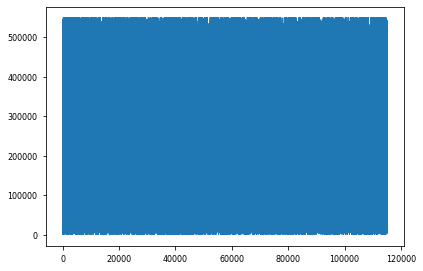

In [1018]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, linewidth=1, label="original")
plt.plot(x_ax, y_pred, linewidth=1.1, label="predicted")
plt.title("y-test and y-predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

# Анализ feature importance

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)
# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Text(0.5, 1.0, 'Feature Importance')

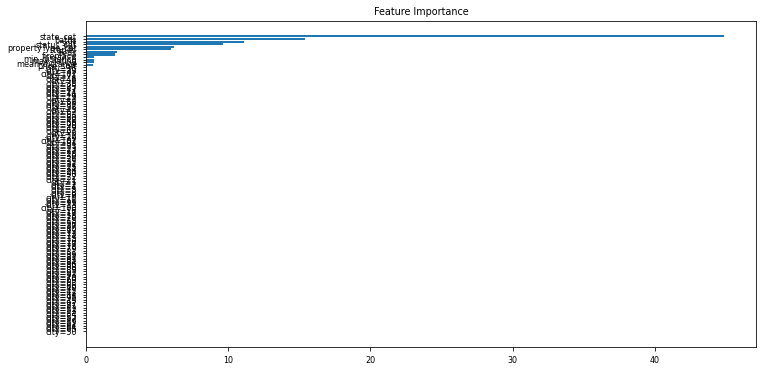

In [1017]:
feature_importance=catboost.feature_importances_
sorted_idx=np.argsort(feature_importance)
fig=plt.figure(figsize=(12,6))
plt.barh(range(len(sorted_idx)),feature_importance[sorted_idx],align='center')
plt.yticks(range(len(sorted_idx)),np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')